# Cancer Treatment
## Business Understanding

Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature. For this study we are using MSKCC Data set which has an expert-annotated knowledge base where  researchers and oncologists have manually annotated thousands of mutations. We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

<br>

Data Credits : [Kaggle - Memorial Sloan Kettering Cancer Center (MSKCC)](https://www.kaggle.com/c/msk-redefining-cancer-treatment/data)

### Domain Review
- [forbes](https://www.forbes.com/sites/matthewherper/2017/06/03/a-new-cancer-drug-helped-almost-everyone-who-took-it-almost-heres-what-it-teaches-us/#2a44ee2f6b25)
- [video1](https://www.youtube.com/watch?v=UwbuW7oK8rk)
- [video2](https://www.youtube.com/watch?v=qxXRKVompI8)
- [kaggle](https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462)

### Business Objectives and Constraints

- Classify the given genetic variations/mutations based on evidence from text-based clinical literature.
- This model should be useful to decrease the man hours required to solve the problem
- Output a probability of the prediced class so that the pathologist can be confident about the classification 
- The cost of a mis-classification and errors is very high.
- Interpretability is really important.
- No strict latency concerns.

### Machine Learing Problem Statement

- Type of Machine Leaning Problem : It is a multi(9) class classification problem
- Performance Metric :
    - [Cross Entropy or Multi class log-loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
    

#### we will start by importing important libraries and defining some constants

In [1]:
## importing libraries
from utils.base import *
css()

## Defining constants
title = "Cancer Treatment"
raw_training_text_file_path = f"data/{title}/01_raw/training_text.csv"
raw_training_variants_file_path = f"data/{title}/01_raw/training_variants.csv"
raw_training_text_dataprep_report_path = f"Assets/reports/{title}/raw_training_text_dataprep.html"
raw_training_variants_dataprep_report_path = f"Assets/reports/{title}/raw_training_variants_dataprep.html"

## Data Overview

There are 2 datasets available in raw files we will load these into `df_variants` and `df_text`

### Glimpse of `df_variants`

In [2]:
df_variants = pd.read_csv(raw_training_variants_file_path)
glimpse(df_variants)
create_report(df_variants, title=title, progress=False).save(raw_training_variants_dataprep_report_path)

Shape:  (3321, 4)


Info             ID      Gene  Variation     Class
dtype         int64    object     object     int64
# of Nas          0         0          0         0
% of Na         0.0       0.0        0.0       0.0
# of uniques   3321       264       2996         9
% of unique   100.0  7.949413  90.213791  0.271003

Count of dtypes
int64                 2
object                2

Stats           ID        Class
count  3321.000000  3321.000000
mean   1660.000000     4.365854
std     958.834449     2.309781
min       0.000000     1.000000
25%     830.000000     2.000000
50%    1660.000000     4.000000
75%    2490.000000     7.000000
max    3320.000000     9.000000

Sample    ID    Gene        Variation  Class
385      385    TP53            R249W      4
443      443    TP53            G244R      4
2488    2488   BRCA1           W1782C      5
644      644  CDKN2A             E69G      4
2084    2084   MYD88            L265P      7
329      329    ROS1  MSN-ROS1 Fusion      2
1604    1604     VHL            L188Q      4
1113    1113   FANCA         Deletion      1
2543    2543   BRCA1             C27A      4
1628    1628     VHL            R167Q      4

Report has been saved to Assets/reports/Cancer Treatment/raw_training_variants_dataprep.html!


<a href="Assets/reports/Cancer Treatment/raw_training_variants_dataprep.html" target="_blank">Generated Report</a>
### Glimpse of `df_text`

In [3]:
df_text = pd.read_csv(raw_training_text_file_path, sep="\|\|", engine="python", names=["ID","TEXT"], skiprows=1)
glimpse(df_text)
create_report(df_text, title=title, progress=False).save(raw_training_text_dataprep_report_path)

Shape:  (3321, 2)


Info             ID       TEXT
dtype         int64     object
# of Nas          0          5
% of Na         0.0   0.150557
# of uniques   3321       1920
% of unique   100.0  57.813911

Count of dtypes
int64                 1
object                1

Stats           ID
count  3321.000000
mean   1660.000000
std     958.834449
min       0.000000
25%     830.000000
50%    1660.000000
75%    2490.000000
max    3320.000000

Sample    ID                                               TEXT
801      801  Recent efforts to comprehensively characterize...
1945    1945  Mycosis fungoides and Sézary syndrome are prim...
1526    1526  Anaplastic lymphoma kinase (ALK) tyrosine kina...
2735    2735  Abstract' ' ' ' Mutations in the B-Raf gene ha...
1854    1854  The karyotypic chaos exhibited by human epithe...
2786    2786  Mutation screening of the breast and ovarian c...
665      665  Inherited mutations affecting the INK4a/ARF lo...
2234    2234  The tumor suppressor gene PTEN is frequently m...
430      430  The human p53 gene encodes a nuclear protein t...
1278    1278  The three-dimensional structure of the complex...

Report has been saved to Assets/reports/Cancer Treatment/raw_training_text_dataprep.html!


<a href="Assets/reports/Cancer Treatment/raw_training_text_dataprep.html" target="_blank">Generated Report</a>

## Preprocessing of text

In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(df_text,total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        df_text[column][index] = string

In [5]:
#text processing stage.
start_time = time.perf_counter()
for index, row in df_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(df_text, row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.perf_counter() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 24.476304084999995 seconds


In [6]:
# merging both gene_variations and text data based on ID
result = pd.merge(df_variants, df_text,on='ID', how='left')
result.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

In [7]:
result[result.isnull().any(axis=1)]

ID    Gene             Variation  Class TEXT
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN

In [8]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [9]:
result[result['ID'].isin([1109,1277,1407,1639,2755])]

ID    Gene             Variation  Class                         TEXT
1109  1109   FANCA                S1088F      1                 FANCA S1088F
1277  1277  ARID5B  Truncating Mutations      1  ARID5B Truncating Mutations
1407  1407   FGFR3                 K508M      6                  FGFR3 K508M
1639  1639    FLT1         Amplification      6           FLT1 Amplification
2755  2755    BRAF                 G596C      7                   BRAF G596C

### Test, Train and Cross Validation Split

Splitting the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

In [10]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


#### Distribution of $y_i's$ in Train, Test and Cross Validation datasets

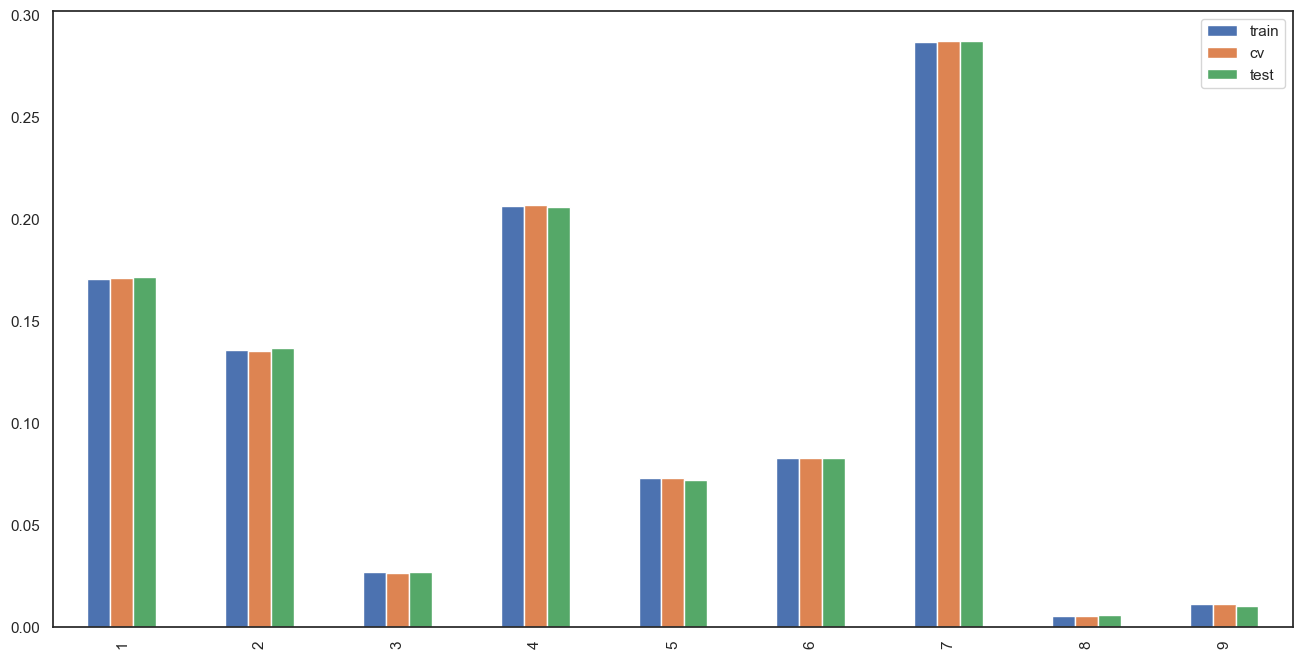

In [12]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()

train_class_distribution_norm = train_class_distribution/train_class_distribution.sum()
cv_class_distribution_norm = cv_class_distribution/cv_class_distribution.sum()
test_class_distribution_norm = test_class_distribution/test_class_distribution.sum()

norm_df = pd.concat([train_class_distribution_norm, cv_class_distribution_norm, test_class_distribution_norm], axis=1)
norm_df.columns = ['train','cv','test']
ax = norm_df.plot(kind='bar', figsize=(16,8))

The distribution is really nice and even amongst the train, test and cross validation

## Random Model Prediction 

Now we will create a random model which would serve as a dumb baseline and we can measure the performace of our model against that model 

Log loss on Cross Validation Data using Random Model 2.503933530991029
Log loss on Test Data using Random Model 2.582919708614705


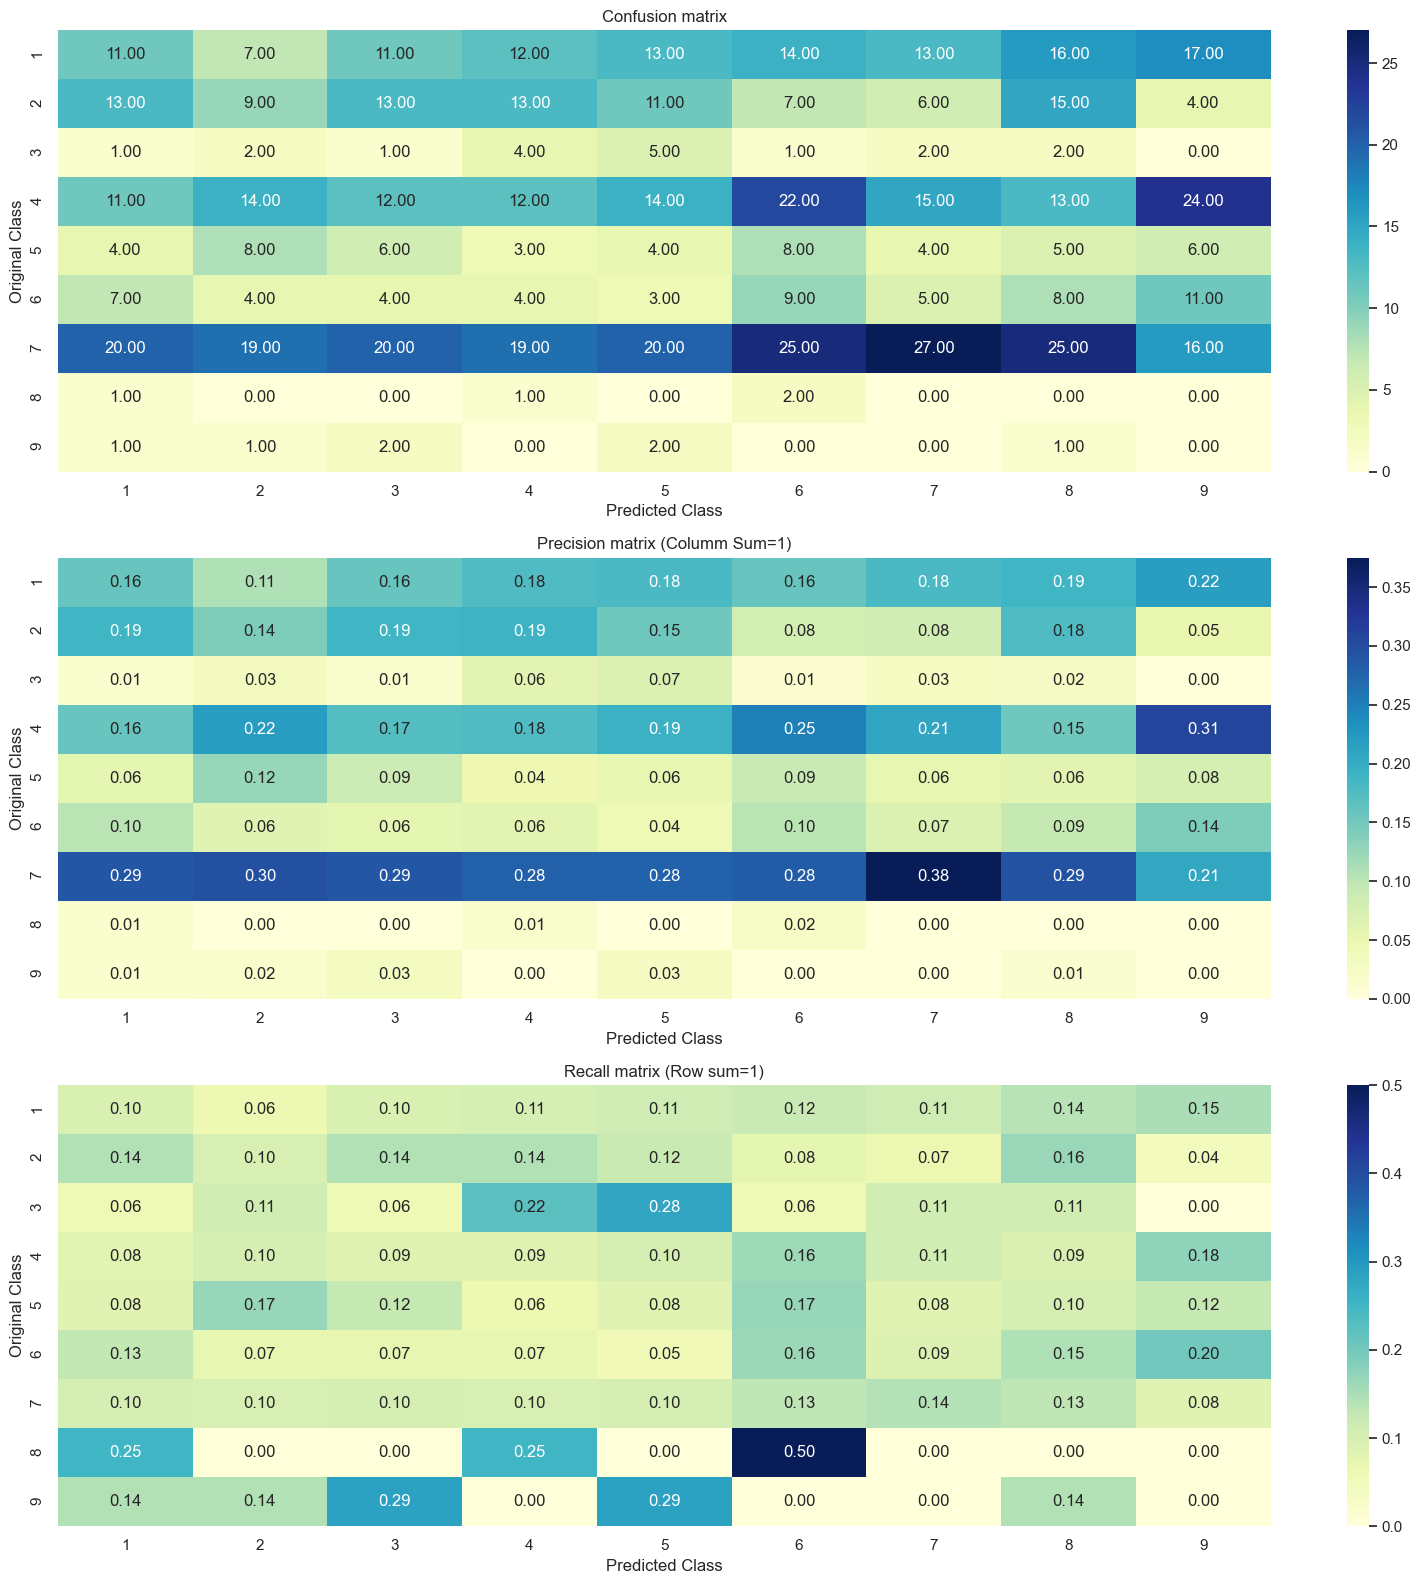

In [13]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):

    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

## Univariate Analysis

### Process Description
#### High Cardinal/Dimensionality Categorical Feature

1. How many categories are there and How they are distributed?

2. How to encode high dimensionality categorical feature ? 
    - One hot Encoding (Higher No of Dimensions)
    - Response coding (Lower No of Dimensions) with laplace smoothing 
        - Laplace smoothing is used during caculation of probability of a feature value belongs to any particular class

#### Text Based Feature
1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to encode text features to numbers?

#### Feature Impact Analysis 

1. How good is a feature in predicting $y_i$?
    - Build an ML model using just the feature in question. For Ex. build a logistic regression model using the feature to predict $y_i$. Compare the results and metrics with the Random Model prediction.

2. Is the feature stable across all the data sets (Test, Train, Cross validation)
    - Check the distribution across Train and Cross validation sets
    - Check the metrics for Cross validation and Test sets done in Impact Analysis (should be comparable to train)
    - Coverage: How many data points in Test and CV datasets are covered by the unique feature values in train dataset?


### EDA

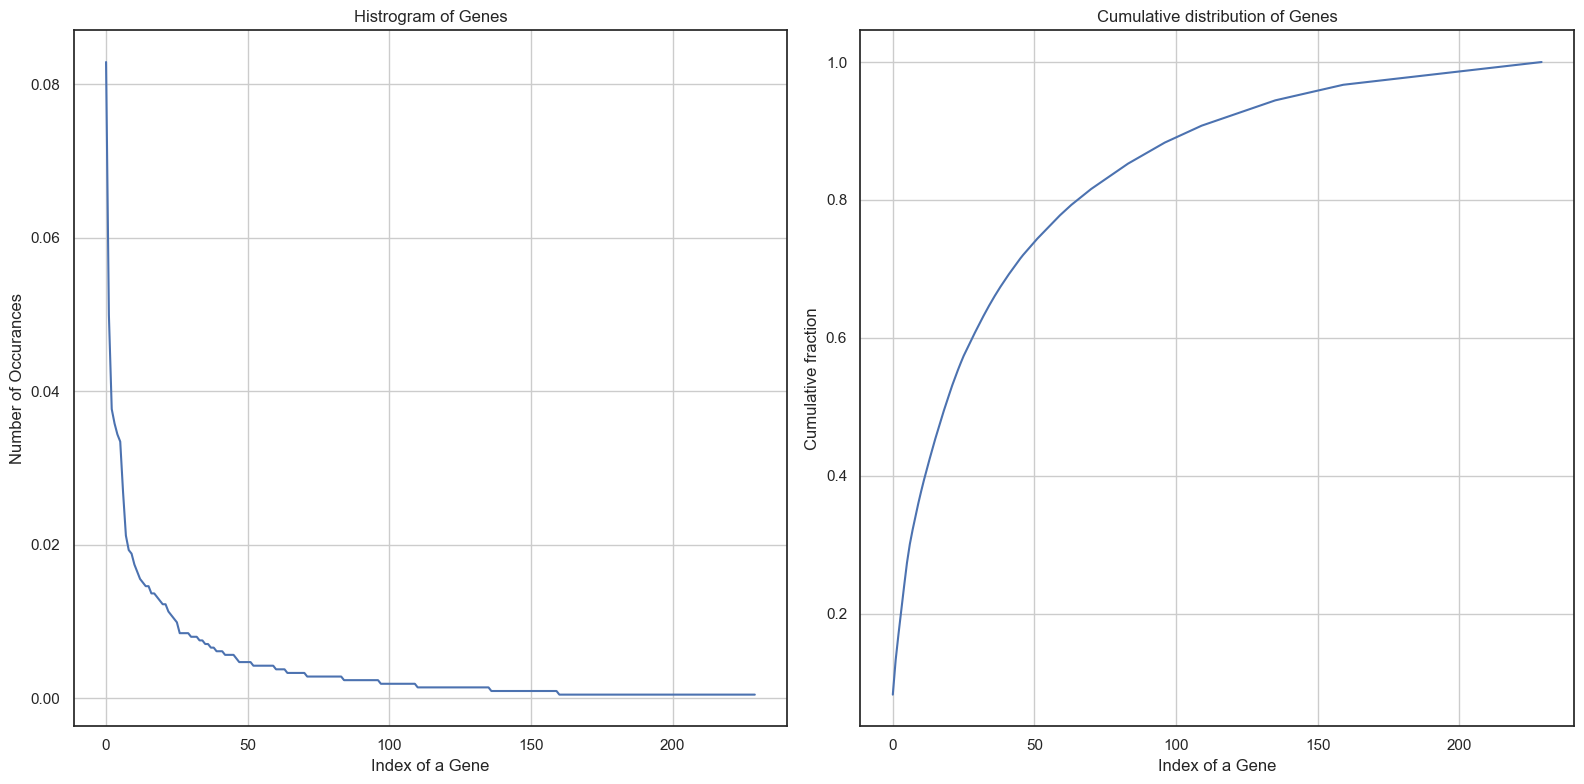

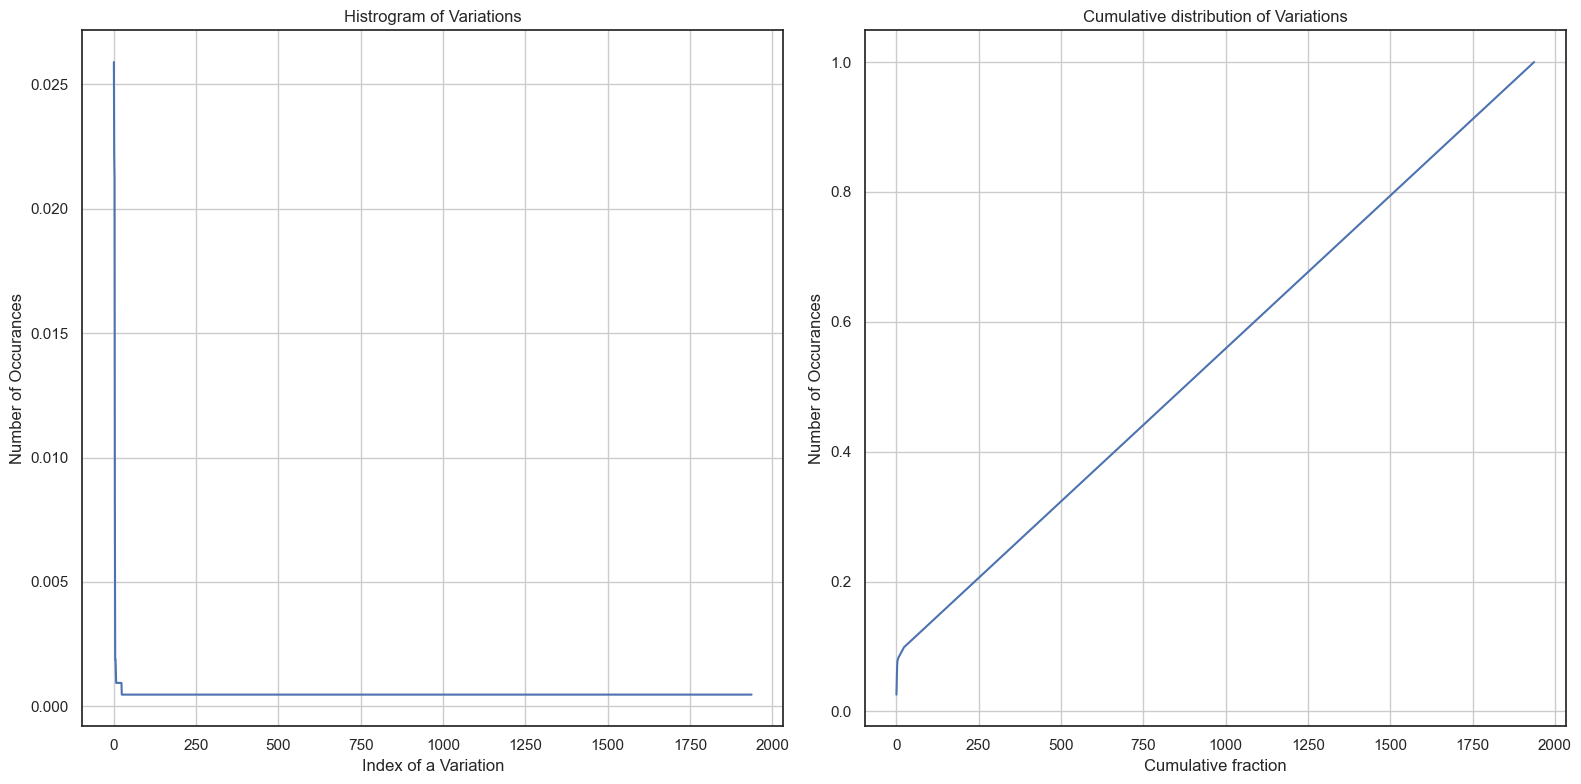

In [14]:
unique_genes = train_df['Gene'].value_counts()
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)

fig,ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(h)
ax[0].set_xlabel('Index of a Gene')
ax[0].set_ylabel('Number of Occurances')
ax[0].set_title("Histrogram of Genes")
ax[0].grid()

ax[1].plot(c)
ax[1].set_xlabel('Index of a Gene')
ax[1].set_ylabel('Cumulative fraction')
ax[1].set_title("Cumulative distribution of Genes")
ax[1].grid()
plt.tight_layout()

unique_variations = train_df['Variation'].value_counts()
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(h)
ax[0].set_xlabel('Index of a Variation')
ax[0].set_ylabel('Number of Occurances')
ax[0].set_title('Histrogram of Variations')
ax[0].grid()

ax[1].plot(c)
ax[1].set_xlabel('Cumulative fraction')
ax[1].set_ylabel('Number of Occurances')
ax[1].set_title('Cumulative distribution of Variations')
ax[1].grid()
plt.tight_layout()

### Feature Transformation
#### Gene Feature

In [15]:
# Response coding
target = 'Class' 
feature = 'Gene' 
laplace_alpha = 10

train_gene_feature_responseCoding, cv_gene_feature_responseCoding, test_gene_feature_responseCoding = get_response_coded_feature(train_df, cv_df, test_df, feature, target, laplace_alpha)
print("train_gene_feature_responseCoding : shape of feature:", train_gene_feature_responseCoding.shape)

# one hot encoding
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df[feature])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df[feature])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df[feature])

print("train_gene_feature_onehotCoding : shape of feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_responseCoding : shape of feature: (2124, 9)
train_gene_feature_onehotCoding : shape of feature: (2124, 229)


#### Variation Feature

In [16]:
# Response coding
target = 'Class' 
feature = 'Variation' 
laplace_alpha = 10

train_variation_feature_responseCoding, cv_variation_feature_responseCoding, test_variation_feature_responseCoding = get_response_coded_feature(train_df, cv_df, test_df, feature, target, laplace_alpha)
print("train_variation_feature_responseCoding : shape of feature:", train_variation_feature_responseCoding.shape)

# one hot encoding
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

print("train_variation_feature_onehotCoding : shape of feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_responseCoding : shape of feature: (2124, 9)
train_variation_feature_onehotCoding : shape of feature: (2124, 1967)


#### Text Feature

In [17]:
feature = 'TEXT'
target = 'Class'

# # One Hot Encoding
# # building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df[feature])
train_text_features = text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_feature_counts = train_text_feature_onehotCoding.sum(axis=0).A1
text_feature_dict = dict(zip(train_text_features,train_text_feature_counts))

# Use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df[feature])
test_text_feature_onehotCoding = text_vectorizer.transform(test_df[feature])

# Normalise
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# # Response Coding
def words_value_count_in_text_df(df, feature):
    text_split = pd.DataFrame(df[feature].str.split().tolist(), index=df.index)
    dictionary = defaultdict(int, text_split.unstack().value_counts().to_dict())
    return dictionary

def get_text_responsecoding(df, class_dict_list, total_dict, feature, target):
    no_of_classes = len(df[target].unique())
    text_feature_responseCoding = np.zeros((df.shape[0],no_of_classes))
    for i in range(0, no_of_classes):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row[feature].split():
                sum_prob += math.log(((class_dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row[feature].split()))
            row_index += 1
    return text_feature_responseCoding

class_dict_list = []
for i in range(1,10):
    class_text_df = train_df[train_df[target] == i]
    dictionary = words_value_count_in_text_df(class_text_df, feature)
    class_dict_list.append(dictionary)
total_dict = words_value_count_in_text_df(train_df, feature)

train_text_feature_responseCoding  = get_text_responsecoding(train_df, class_dict_list, total_dict, feature, target)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df, class_dict_list, total_dict, feature, target)
test_text_feature_responseCoding  = get_text_responsecoding(test_df, class_dict_list, total_dict, feature, target)

train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T

### Transformed Feature EDA 

train_gene_feature_responseCoding


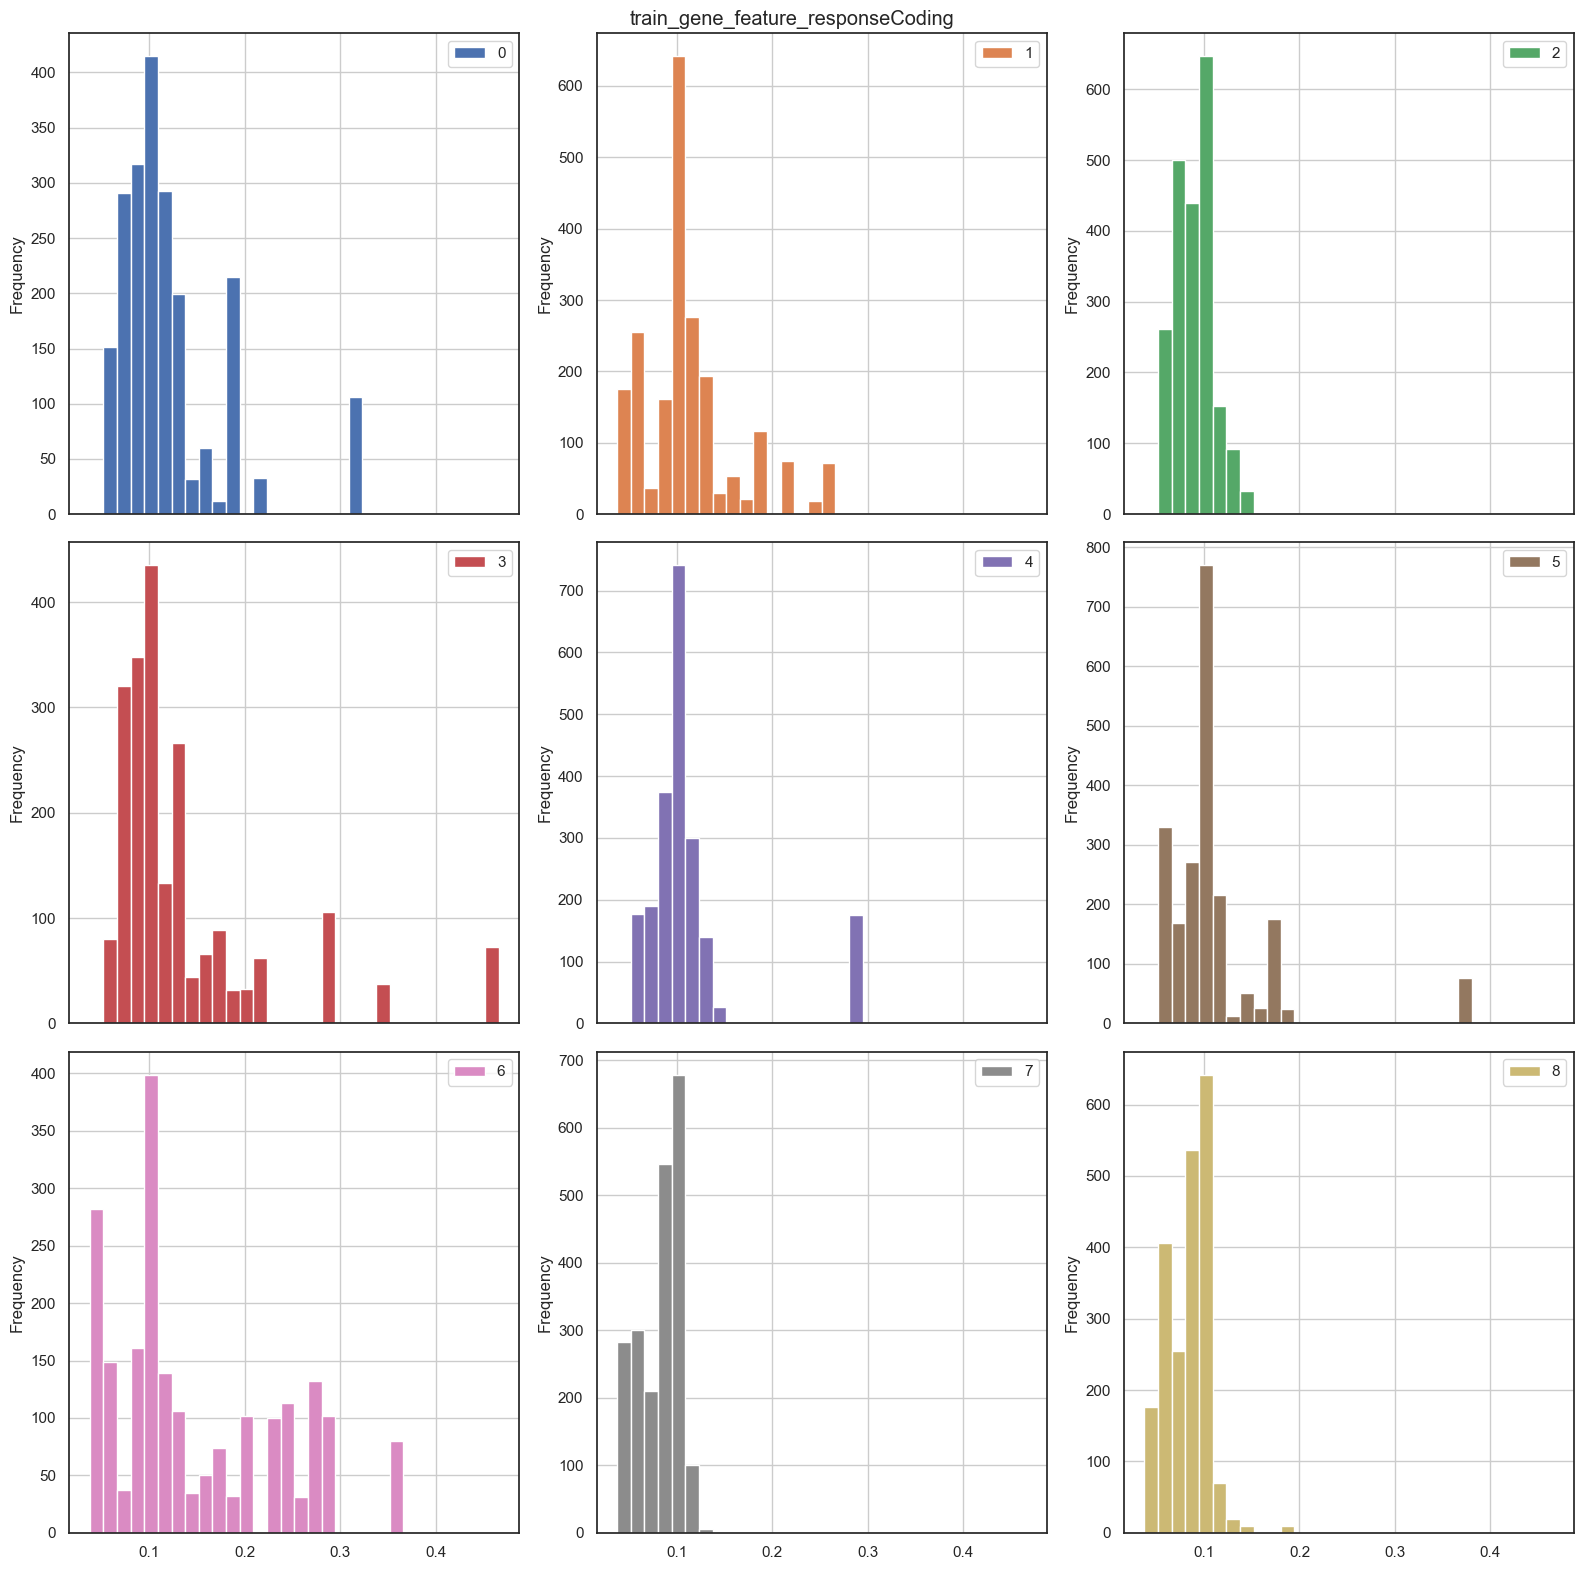

train_variation_feature_responseCoding


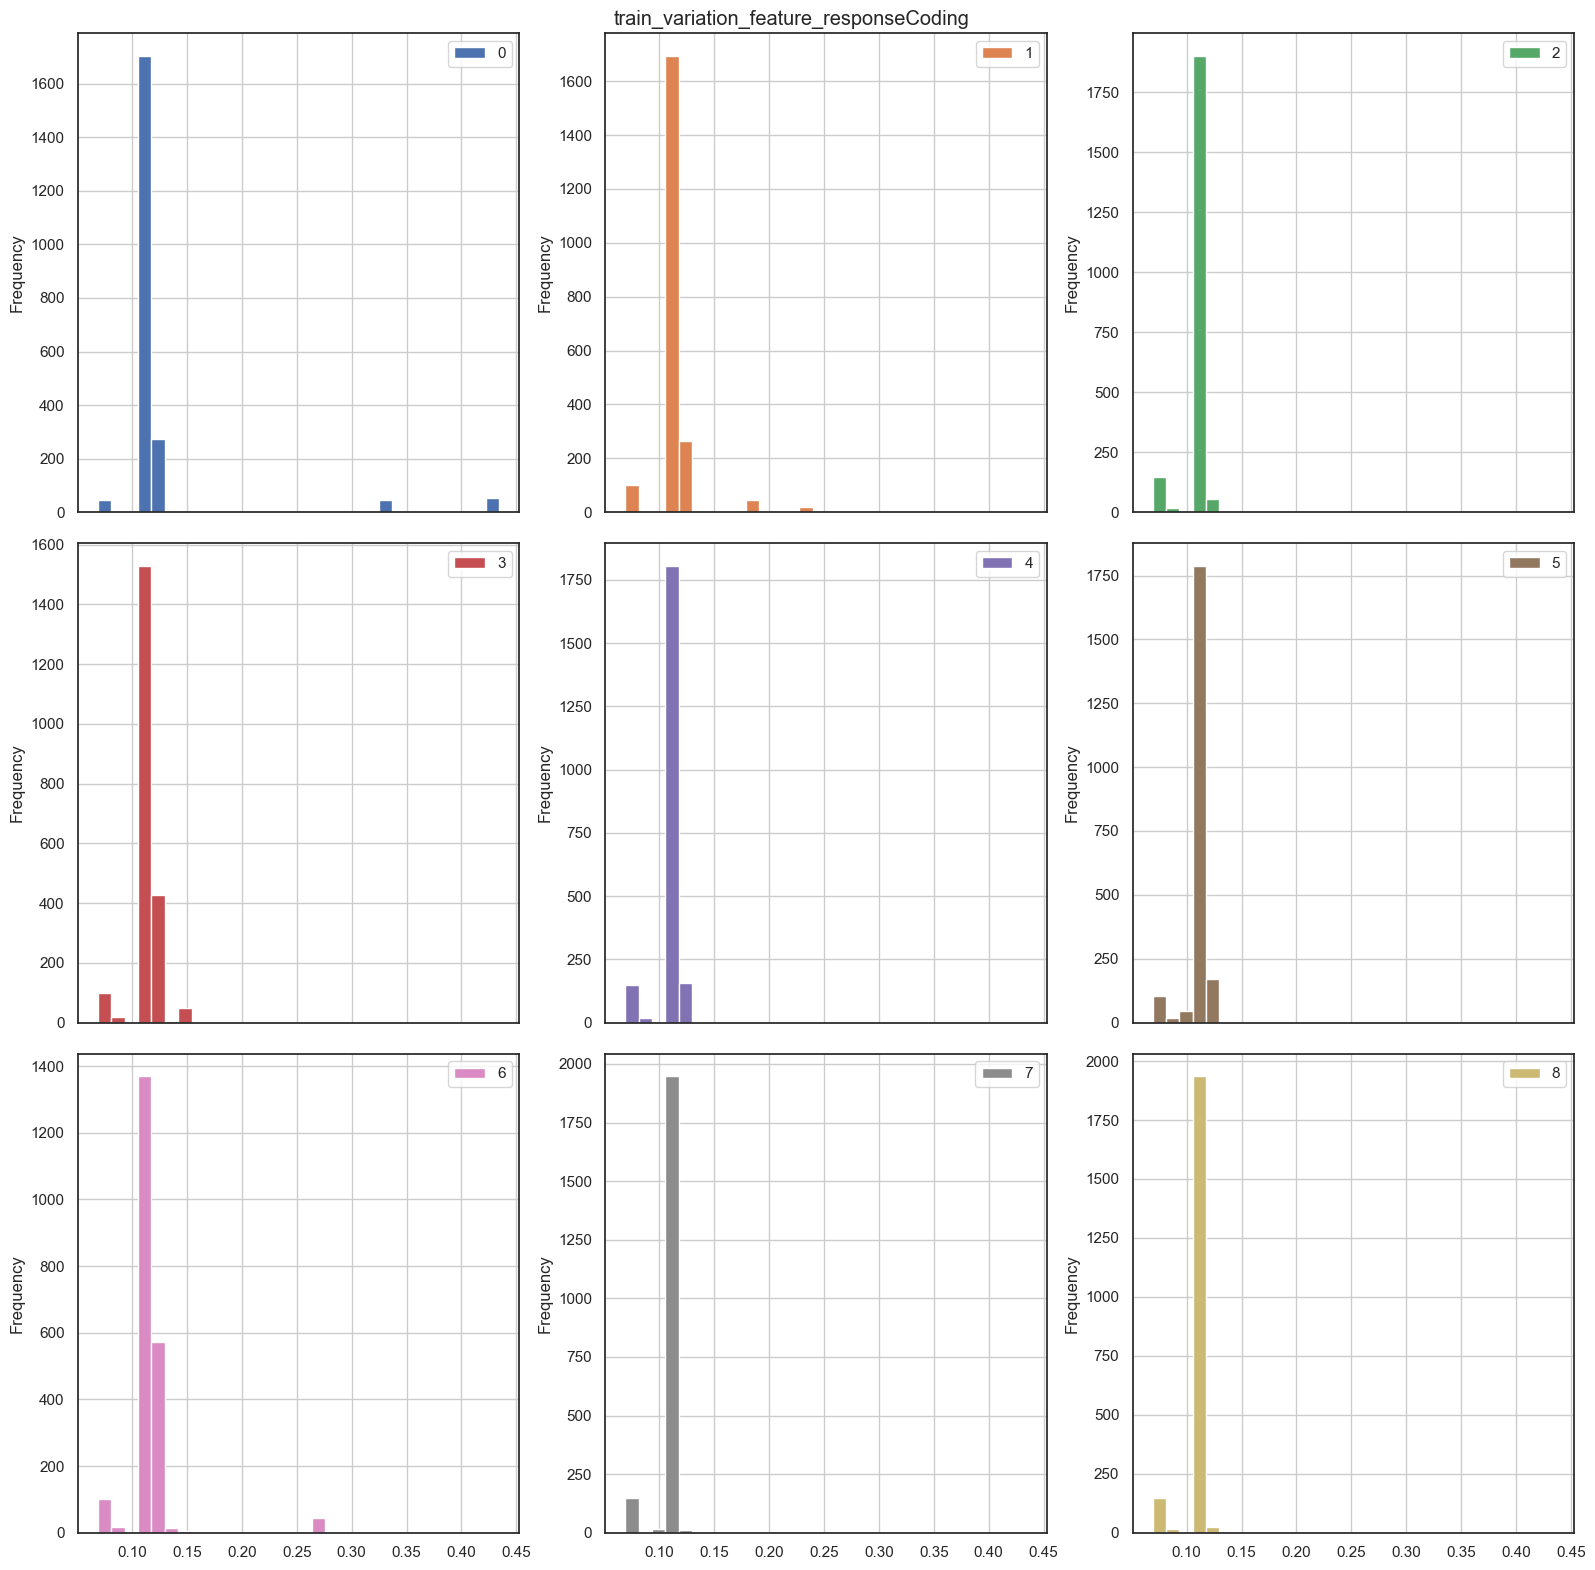

train_text_feature_responseCoding


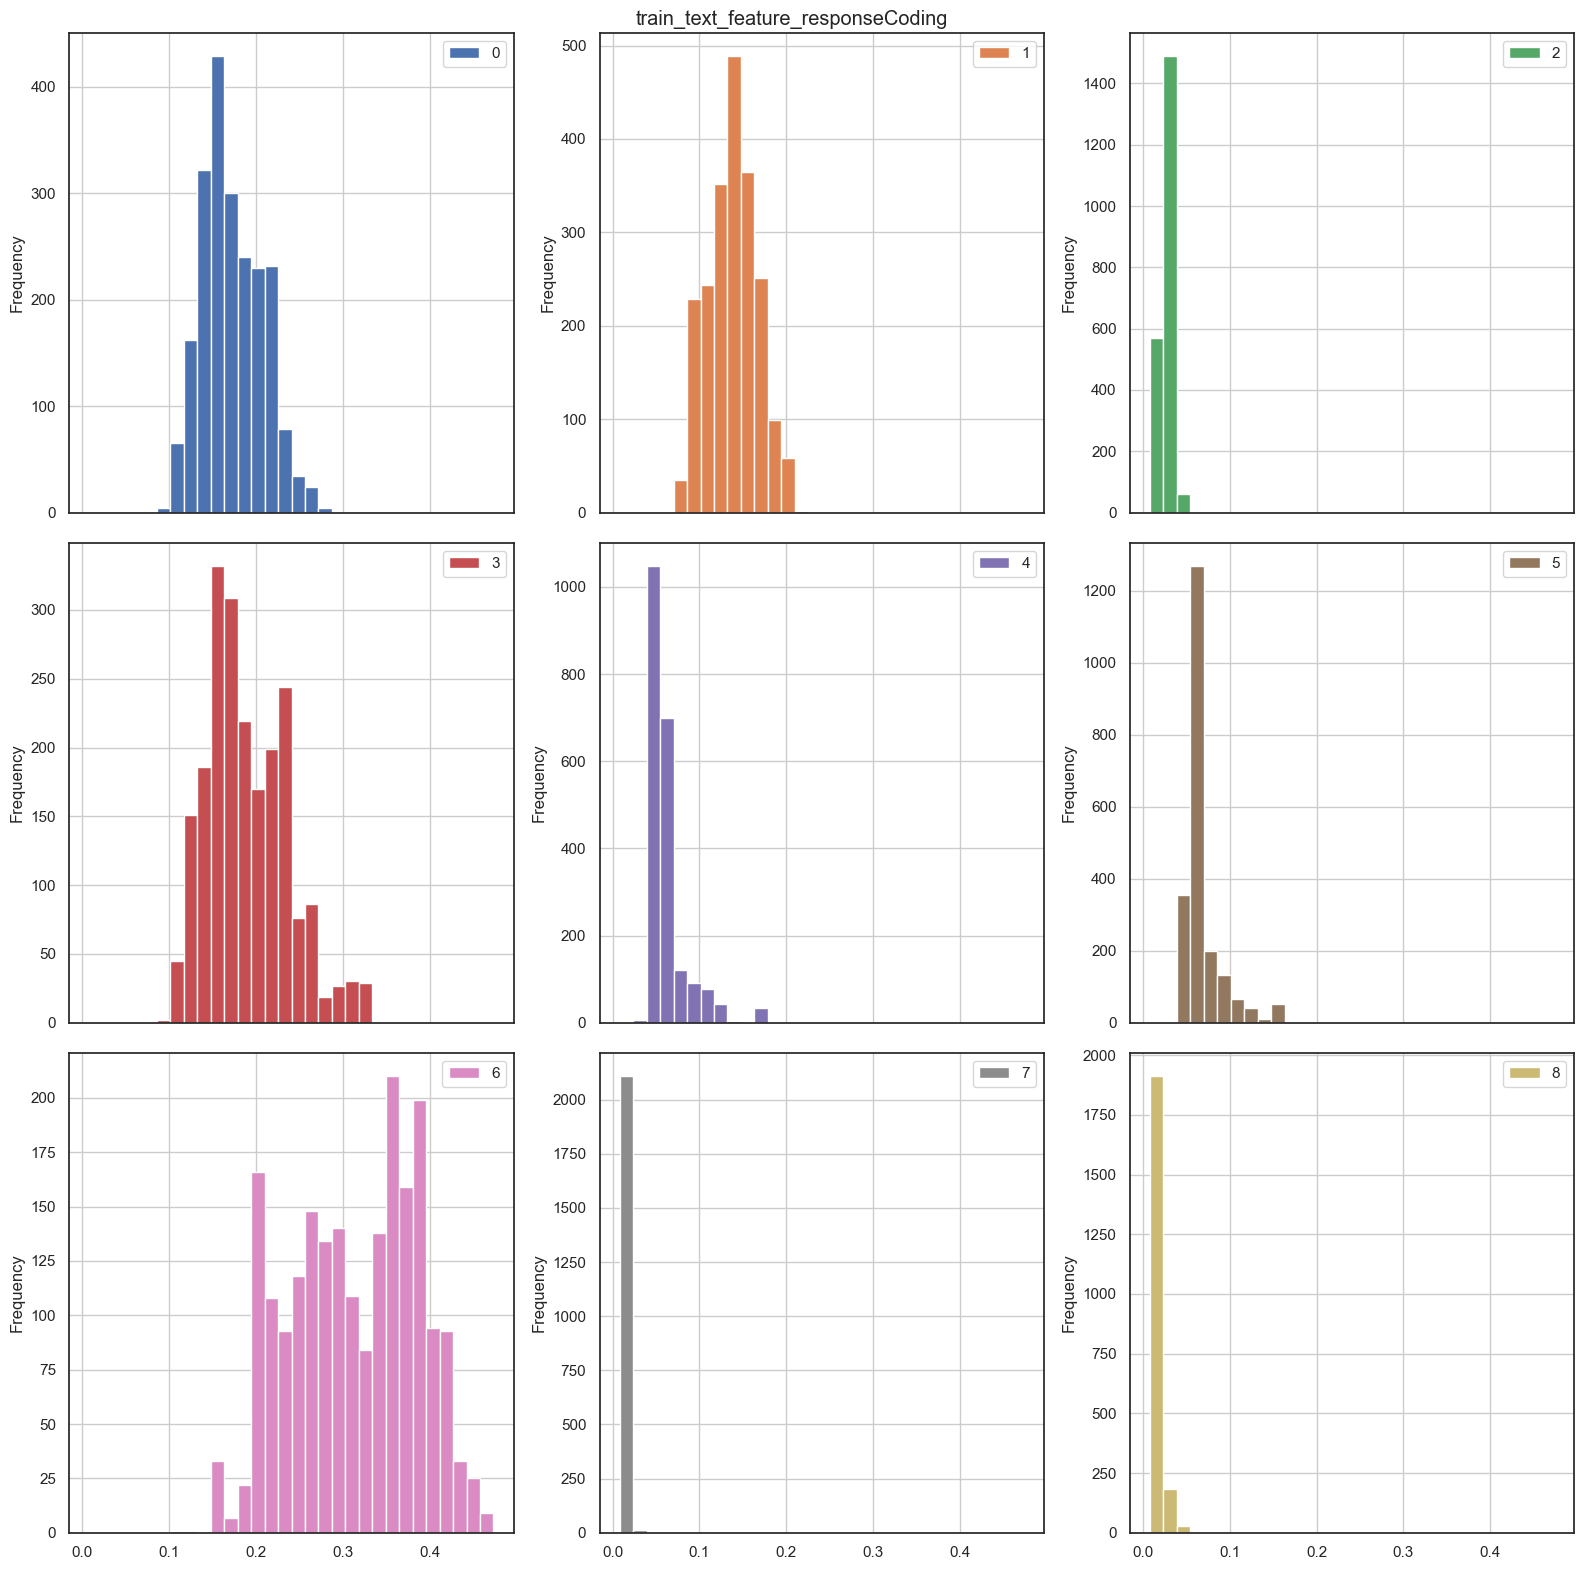

train_text_feature_onehotCoding


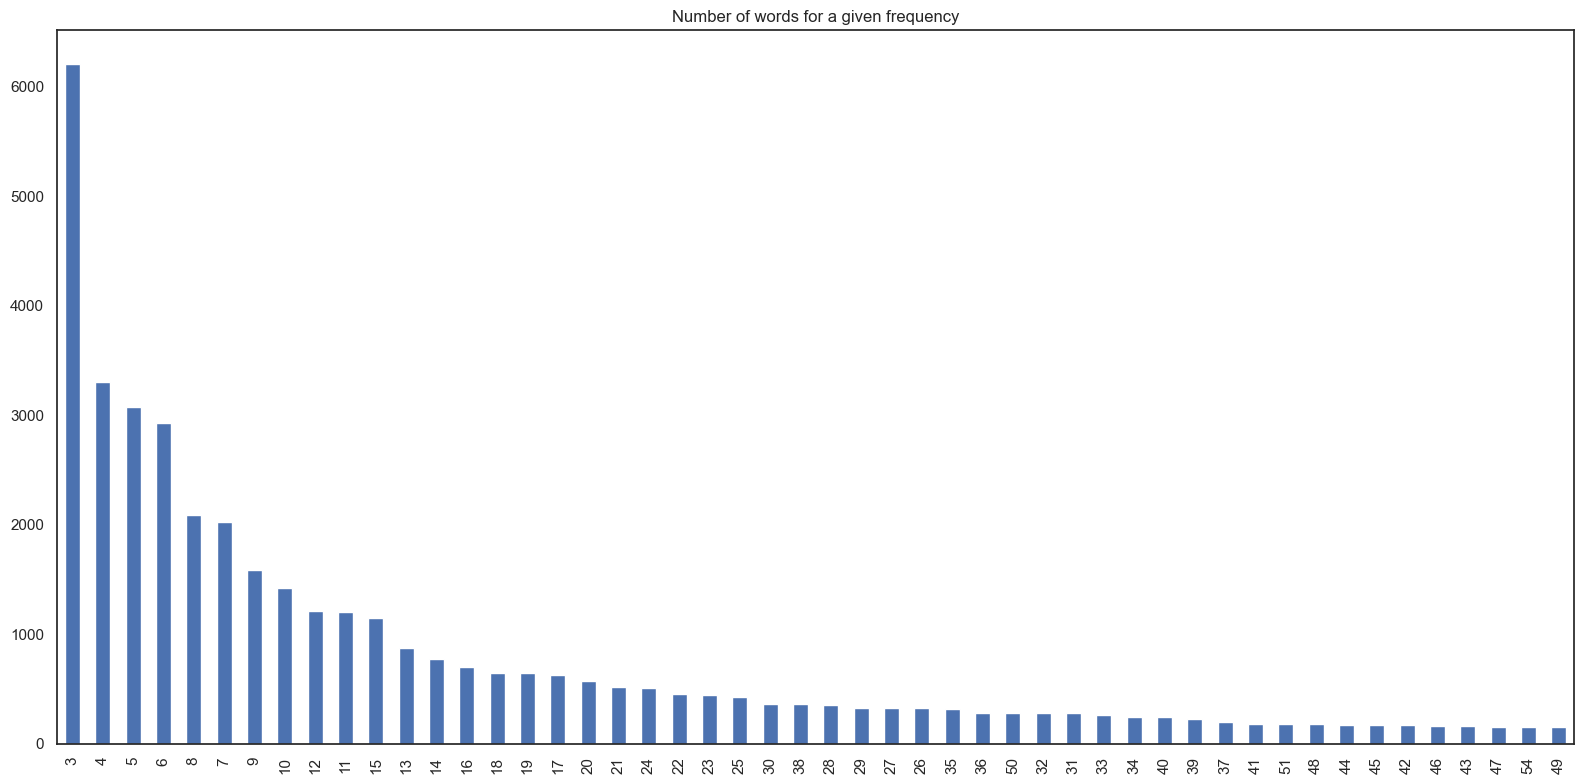

In [18]:
print('train_gene_feature_responseCoding')
_ = pd.DataFrame(train_gene_feature_responseCoding).plot(bins=30, kind='hist', subplots=True, figsize=(16,16),layout=(3,3),  title='train_gene_feature_responseCoding', grid=True)
plt.tight_layout()
plt.show()

print('train_variation_feature_responseCoding')
_ = pd.DataFrame(train_variation_feature_responseCoding).plot(bins=30, kind='hist', subplots=True, figsize=(16,16),layout=(3,3), title='train_variation_feature_responseCoding', grid=True)
plt.tight_layout()
plt.show()

print('train_text_feature_responseCoding')
_ = pd.DataFrame(train_text_feature_responseCoding).plot(bins=30, kind='hist', subplots=True, figsize=(16,16),layout=(3,3), title='train_text_feature_responseCoding', grid=True)
plt.tight_layout()
plt.show()

print('train_text_feature_onehotCoding')
sorted_text_feature_dict = dict(sorted(text_feature_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_feature_dict.values()))
_ = pd.Series(Counter(sorted_text_occur)).sort_values(ascending=False)[:50].plot(kind='bar', figsize=(16,8), title='Number of words for a given frequency')
plt.tight_layout()
plt.show()

### Impact Anlaysis
#### Gene Feature One hot Encoded using SGD classifier + Calibration model with Log Loss

For values of alpha =  1e-05 The log loss is: 1.225157977779788
For values of alpha =  0.0001 The log loss is: 1.2186194232146514
For values of alpha =  0.001 The log loss is: 1.2698771600985577
For values of alpha =  0.01 The log loss is: 1.3892311253795766
For values of alpha =  0.1 The log loss is: 1.4786048680300583
For values of alpha =  1 The log loss is: 1.517888924555487


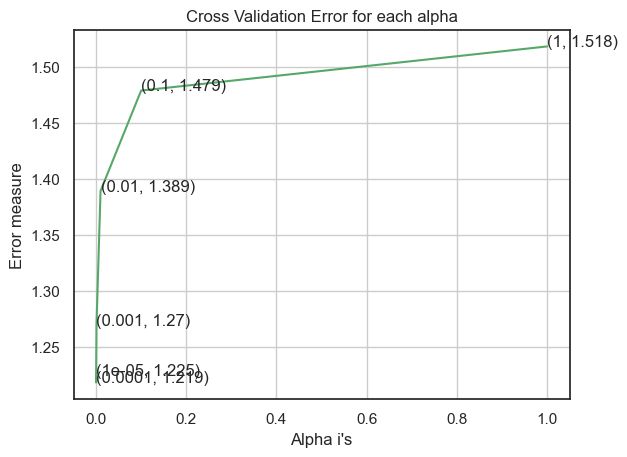

For values of best alpha =  0.0001 The train log loss is: 0.9626738410932817
For values of best alpha =  0.0001 The cross validation log loss is: 1.2186194232146514
For values of best alpha =  0.0001 The test log loss is: 1.213990889587606


In test data 645 out of 665 : 96.99 %
In cross validation data 511 out of  532 : 96.05 %


In [19]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
print('\n')

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('In test data', test_coverage, 'out of',test_df.shape[0], ":",round((test_coverage/test_df.shape[0])*100,2), '%')
print('In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,round((cv_coverage/cv_df.shape[0])*100,2), '%')

Since, the CV and Test errors are similar to the train error, Gene feature is Stable

#### Variation Feature One hot Encoded using SGD classifier + Calibration model with Log Loss

For values of alpha =  1e-05 The log loss is: 1.6880748869472166
For values of alpha =  0.0001 The log loss is: 1.6848972129901907
For values of alpha =  0.001 The log loss is: 1.6873507994191796
For values of alpha =  0.01 The log loss is: 1.694110632040056
For values of alpha =  0.1 The log loss is: 1.7001843816504443
For values of alpha =  1 The log loss is: 1.7015408337552536


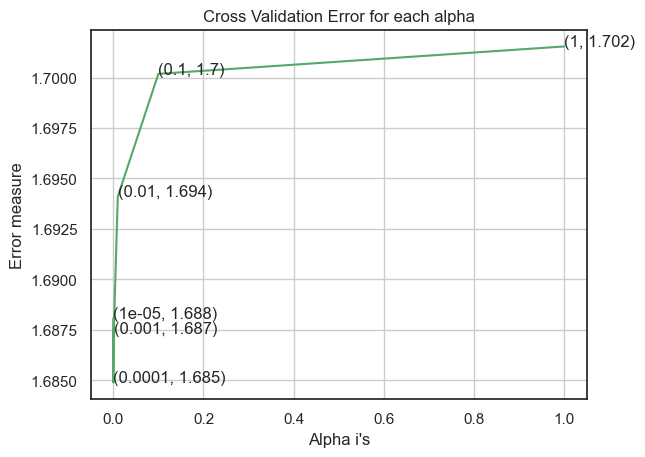

For values of best alpha =  0.0001 The train log loss is: 0.6457223722823235
For values of best alpha =  0.0001 The cross validation log loss is: 1.6848972129901907
For values of best alpha =  0.0001 The test log loss is: 1.707051708439472


In test data 68 out of 665 : 10.225563909774436
In cross validation data 66 out of  532 : 12.406015037593985


In [20]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

print('\n')
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Since, the CV and Test errors are not so similar to the train error, Variation feature is unstable

#### Text Feature One hot Encoded using SGD classifier  + Calibration model with Log Loss

For values of alpha =  1e-05 The log loss is: 1.3417099148783505
For values of alpha =  0.0001 The log loss is: 1.2077311513227988
For values of alpha =  0.001 The log loss is: 1.2220108736944972
For values of alpha =  0.01 The log loss is: 1.3291070684522948
For values of alpha =  0.1 The log loss is: 1.4905994716927748
For values of alpha =  1 The log loss is: 1.6978774030031254


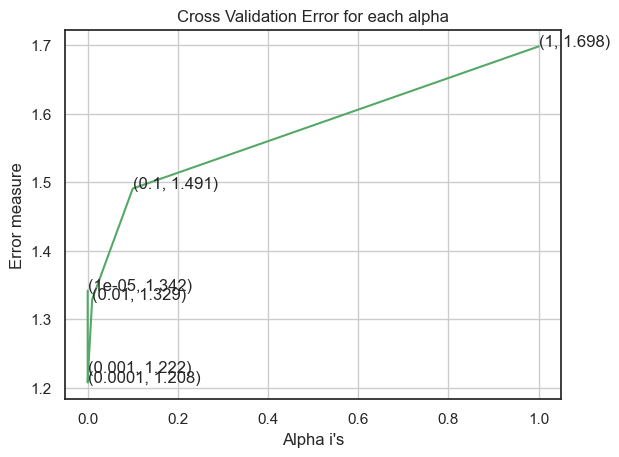

For values of best alpha =  0.0001 The train log loss is: 0.6505120004239873
For values of best alpha =  0.0001 The cross validation log loss is: 1.2077311513227988
For values of best alpha =  0.0001 The test log loss is: 1.2064042366178185


In [21]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Text feature is stable across all the data sets (Test, Train, Cross validation)

In [22]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [23]:
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")

97.986 % of word of Cross Validation appeared in train data
96.803 % of word of test data appeared in train data


## Machine Learning Models

In [24]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)
    
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### Stacking all features

In [25]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55944)
(number of data points * number of features) in test data =  (665, 55944)
(number of data points * number of features) in cross validation data = (532, 55944)


In [26]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


### Naive Bayes

for alpha = 1e-05
Log Loss : 1.2954975305870766
for alpha = 0.0001
Log Loss : 1.2869374246985383
for alpha = 0.001
Log Loss : 1.2842631205424986
for alpha = 0.1
Log Loss : 1.2815875568364257
for alpha = 1
Log Loss : 1.2995403679730142
for alpha = 10
Log Loss : 1.3512446897455843
for alpha = 100
Log Loss : 1.3322494833632648
for alpha = 1000
Log Loss : 1.2809048617321397


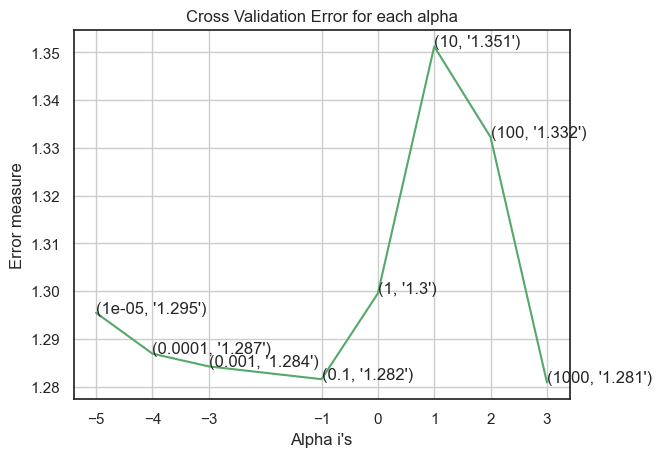

For values of best alpha =  1000 The train log loss is: 1.0285530527044575
For values of best alpha =  1000 The cross validation log loss is: 1.2809048617321397
For values of best alpha =  1000 The test log loss is: 1.2867053550420369


In [27]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Model Testing with best hyper paramters

Log Loss : 1.2809048617321397
Number of missclassified point : 0.40789473684210525


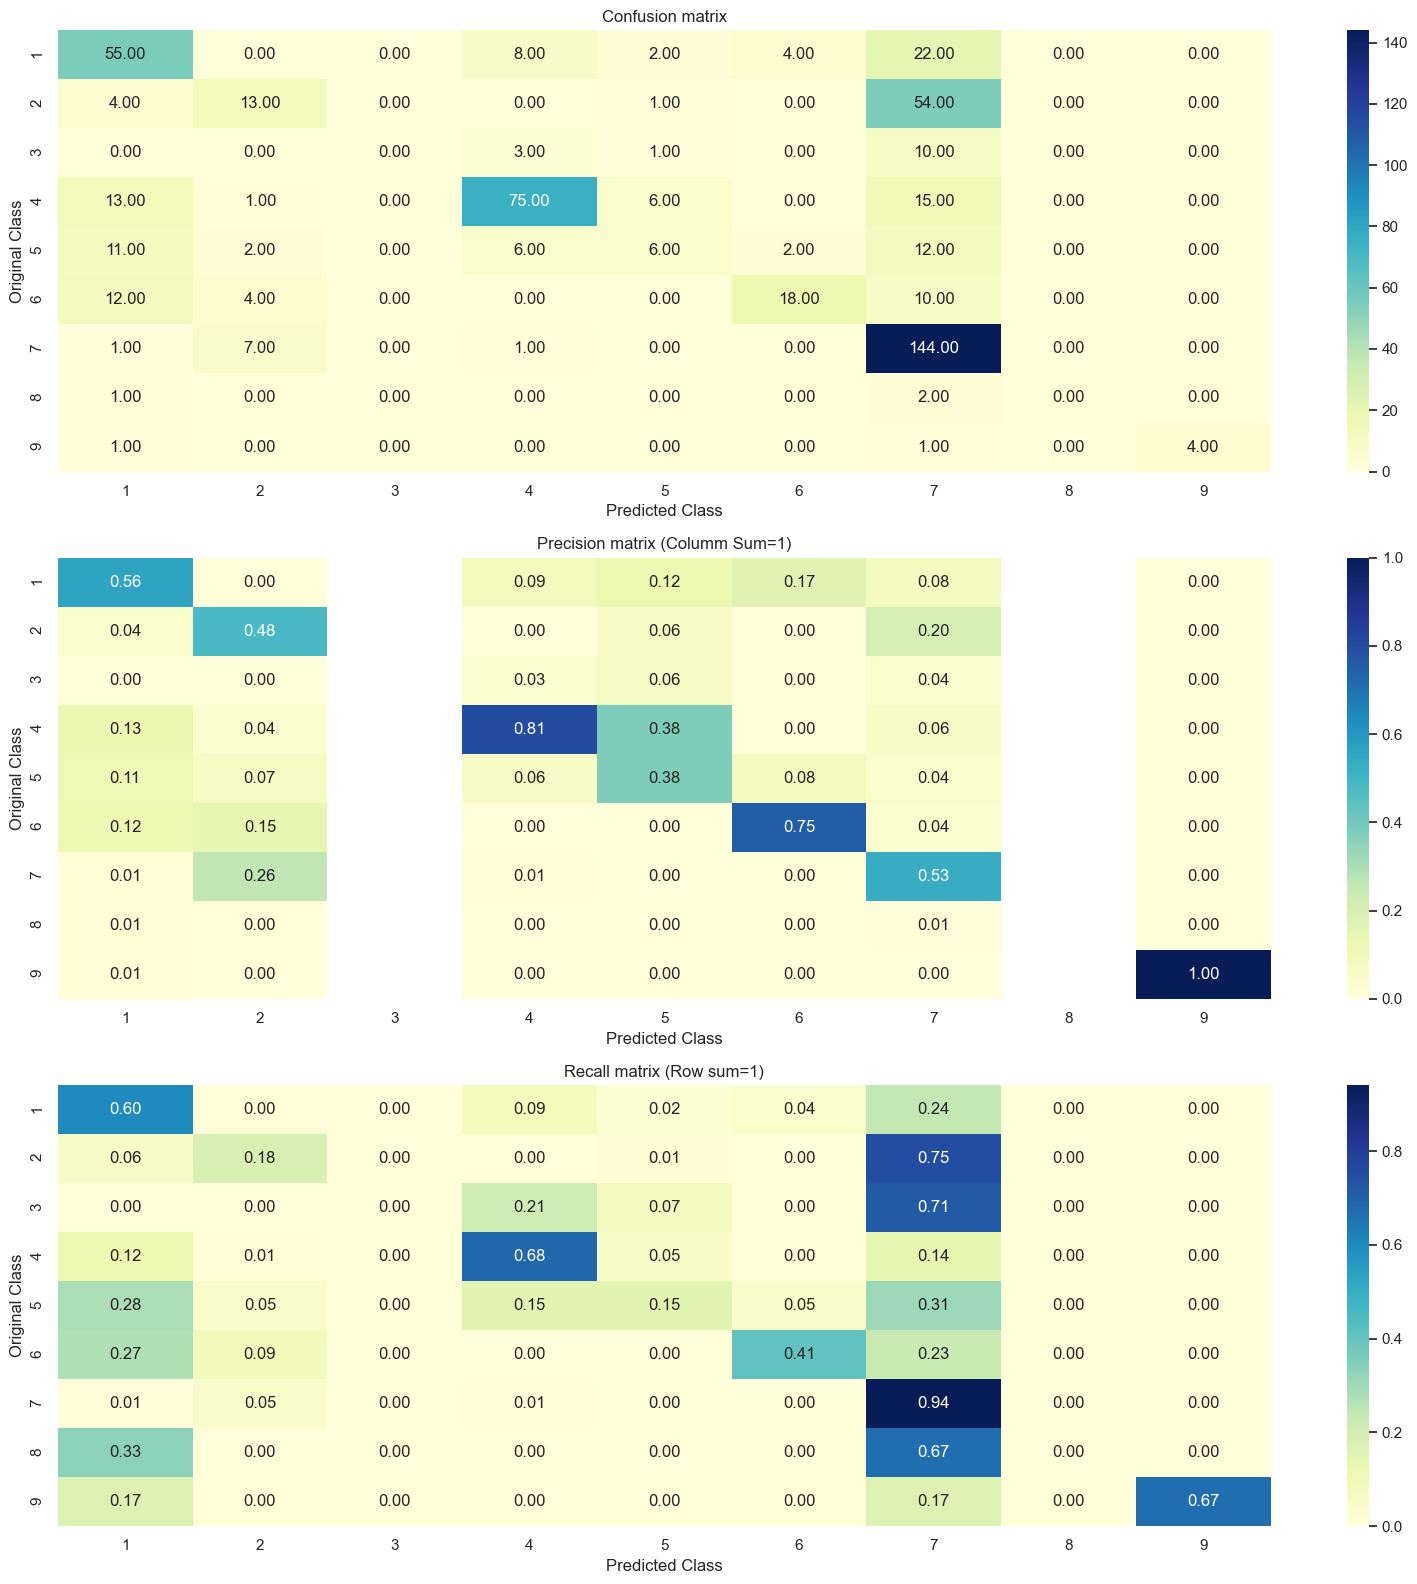

In [28]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### Feature Importance, Correctly classified point

In [29]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.4597 0.1588 0.0104 0.0636 0.0274 0.0241 0.2489 0.0059 0.0011]]
Actual Class : 1
--------------------------------------------------
12 Text feature [dna] present in test data point [True]
13 Text feature [type] present in test data point [True]
14 Text feature [function] present in test data point [True]
15 Text feature [protein] present in test data point [True]
17 Text feature [one] present in test data point [True]
18 Text feature [two] present in test data point [True]
19 Text feature [containing] present in test data point [True]
20 Text feature [region] present in test data point [True]
21 Text feature [wild] present in test data point [True]
22 Text feature [loss] present in test data point [True]
23 Text feature [conserved] present in test data point [True]
24 Text feature [amino] present in test data point [True]
25 Text feature [sequence] present in test data point [True]
26 Text feature [possible] present in test data poi

In [30]:
test_df['TEXT'].iloc[test_point_index]

'introduction platinum based chemotherapy standard care patients muscle invasive metastatic urothelial carcinoma 20 years 1 3 neoadjuvant cisplatin based chemotherapy leads 14 25 relative risk reduction death muscle invasive urothelial carcinoma ct2 t4an0m0 refs 3 5 pathologic downstaging complete response pt0 carcinoma situ ptis cystectomy occurs 26 38 patients treated neoadjuvant chemotherapy compared 12 3 15 patients undergoing cystectomy alone 3 4 6 5 year survival pt0 ptis patients 85 neoadjuvant chemotherapy 3 compared 43 patients persistent muscle invasive disease pt2 ref 7 therefore benefit neoadjuvant chemotherapy seems dramatic patients found pathologic complete responses time surgical resection however inability predict patients derive clinical benefit limited use toxic approach urologic community 8 10 cisplatin causes accumulation dna cross links interfere dna replication gene transcription eventually promotes cell death repair cisplatin induced dna damage occurs primarily 

In [31]:
no_feature

100

In [32]:
test_df['Gene'].iloc[test_point_index]

'ERCC2'

In [33]:
test_df['Variation'].iloc[test_point_index]

'E606G'

In [34]:
clf.feature_log_prob_.shape

(9, 55944)

In [35]:
indices=np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
indices[0]

array([    0, 36561, 36568, 36571, 36582, 36583, 36592, 16154, 16153,
       36558, 36594, 36596, 36597, 36601, 36604, 36607, 36609, 36637,
       36638, 36595, 36557, 36556, 36552, 36530, 36531, 36532, 36533,
       36534, 36535, 36536, 16180, 16179, 36537, 36538, 16176, 36539,
       36540, 36541, 36542, 36547, 36551, 16169, 36639, 36643, 36647,
       16139, 16111, 36718, 36719, 36721, 16106, 36722, 16104, 36725,
       36726, 16101, 36727, 36729, 16097, 36734, 36735, 36737, 16092,
       36738, 36740, 36715, 36529, 36713, 36704, 16138, 36657, 36660,
       16133, 36666, 36671, 36675, 16129, 36676, 16127, 36678, 36687,
       36688, 36693, 36694, 36695, 36698, 16117, 36702, 36709, 36742,
       36528, 36527, 36445, 36447, 16256, 36448, 36449, 36452, 36455,
       36456])

In [36]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [37]:
for i in range(10):
    test_point_index = i
    no_feature = 100
    predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
    print("Predicted Class :", predicted_cls[0])
    print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
    print("Actual Class :", test_y[test_point_index])
    indices=np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
    print("-"*50)
    get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index].lower(),test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[4.090e-02 1.070e-02 5.400e-03 5.280e-02 7.330e-02 7.635e-01 4.870e-02
  4.300e-03 3.000e-04]]
Actual Class : 6
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 1
Predicted Class Probabilities: [[0.4597 0.1588 0.0104 0.0636 0.0274 0.0241 0.2489 0.0059 0.0011]]
Actual Class : 1
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 7
Predicted Class Probabilities: [[2.480e-02 8.020e-02 5.000e-04 8.200e-03 3.200e-03 1.100e-03 8.782e-01
  3.800e-03 0.000e+00]]
Actual Class : 2
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 7
Predicted Class Probabilities: [[0.0345 0.3528 0.0149 0.0416 0.0342 0.0314 0.4819 0.0067 0.0019]]
Actual Class : 2
--------------------------------------------------
Out of the top  10

#### Feature Importance, Incorrectly classified point

In [38]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[3.800e-02 7.340e-02 3.700e-03 4.260e-02 1.190e-02 9.300e-03 8.155e-01
  5.500e-03 1.000e-04]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


### Nearest Neighbour Classification

#### Hyper parameter tuning

for alpha = 5
Log Loss : 1.1036779125472609
for alpha = 11
Log Loss : 1.0683198189507492
for alpha = 15
Log Loss : 1.0580822704500141
for alpha = 21
Log Loss : 1.0563308294497766
for alpha = 31
Log Loss : 1.0560537205374698
for alpha = 41
Log Loss : 1.0826667857571959
for alpha = 51
Log Loss : 1.0901258431039602
for alpha = 99
Log Loss : 1.1253028140655437


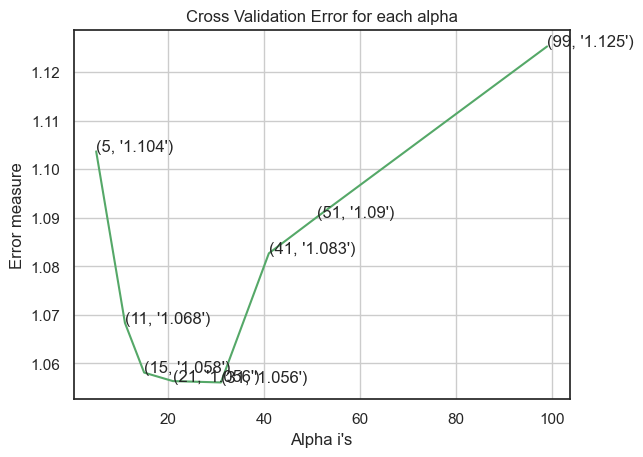

For values of best alpha =  31 The train log loss is: 0.7840473307464905
For values of best alpha =  31 The cross validation log loss is: 1.0560537205374698
For values of best alpha =  31 The test log loss is: 1.1103171665646643


In [39]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### Testing the model with best hyper paramters

Log loss : 1.0560537205374698
Number of mis-classified points : 0.3684210526315789


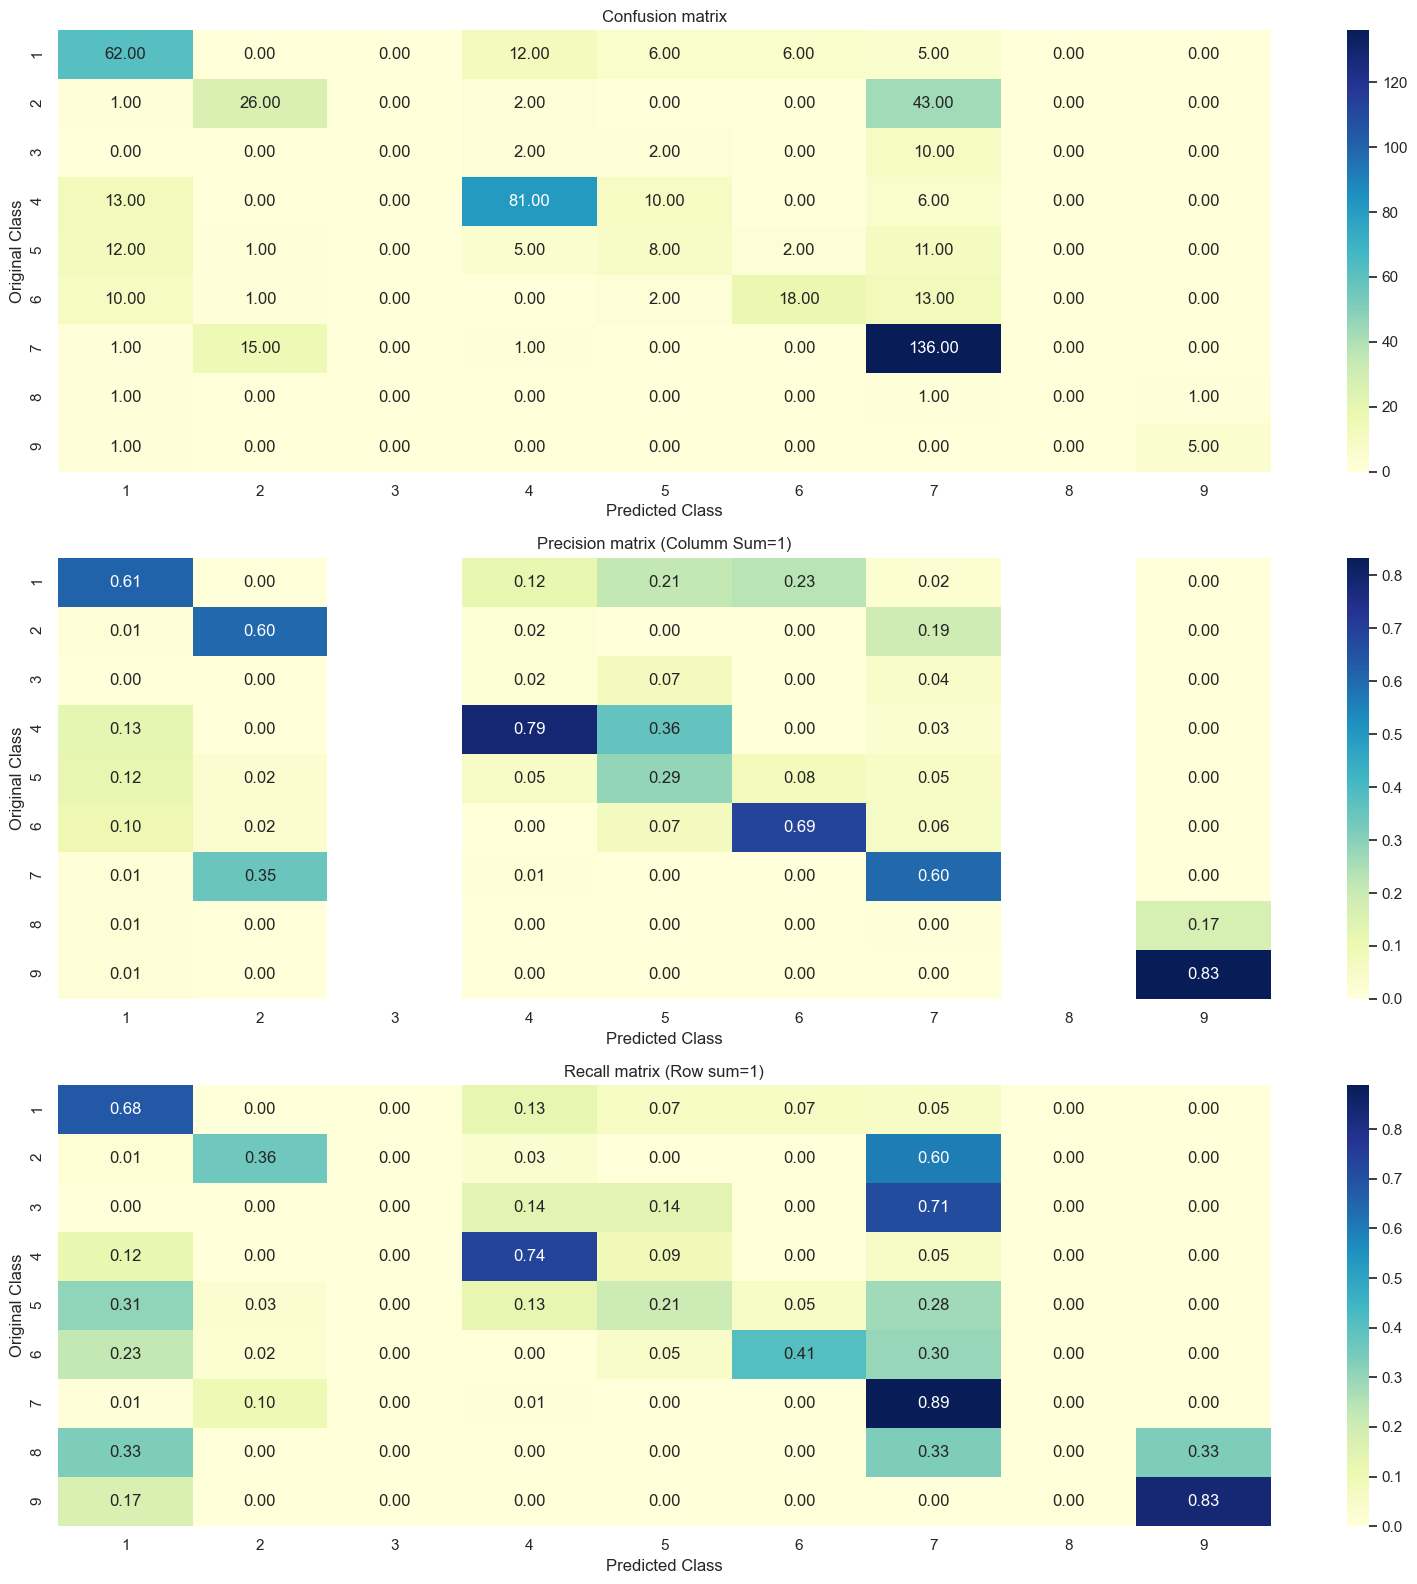

In [40]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

#### Sample Query point -1

In [41]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 6
Actual Class : 1
The  31  nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 4 1 1 1 1 1 1 1 5 1 1 1 1]
Fequency of nearest points : Counter({1: 28, 2: 1, 4: 1, 5: 1})


#### Sample Query Point-2

In [42]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
the k value for knn is 31 and the nearest neighbours of the test points belongs to classes [7 2 7 7 2 7 2 2 2 7 6 7 7 2 7 7 7 7 6 2 7 7 2 7 7 7 2 6 7 2 2]
Fequency of nearest points : Counter({7: 17, 2: 11, 6: 3})


### Logistic Regression
#### Hyper paramter tuning

for alpha = 1e-06
Log Loss : 1.3549611984629366
for alpha = 1e-05
Log Loss : 1.3243830764474769
for alpha = 0.0001
Log Loss : 1.1484035371750703
for alpha = 0.001
Log Loss : 1.1469421660609054
for alpha = 0.01
Log Loss : 1.2277813159484565
for alpha = 0.1
Log Loss : 1.443192254191518
for alpha = 1
Log Loss : 1.6513624798101794
for alpha = 10
Log Loss : 1.6801064048265375
for alpha = 100
Log Loss : 1.6832847660500232


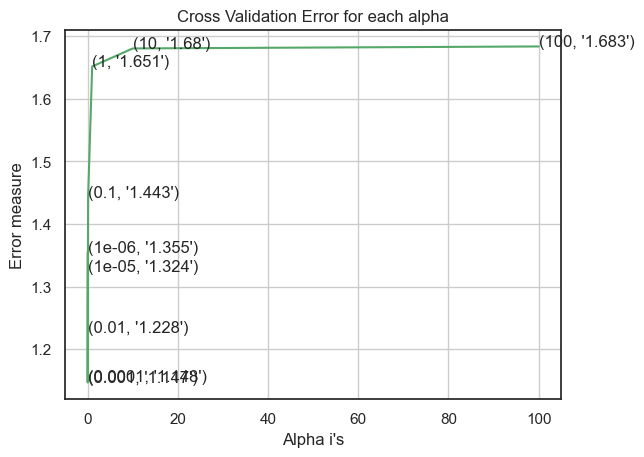

For values of best alpha =  0.001 The train log loss is: 0.5051957904999469
For values of best alpha =  0.001 The cross validation log loss is: 1.1469421660609054
For values of best alpha =  0.001 The test log loss is: 1.1285955963127317


In [43]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Testing the model with best hyper paramters

Log loss : 1.1469421660609054
Number of mis-classified points : 0.35902255639097747


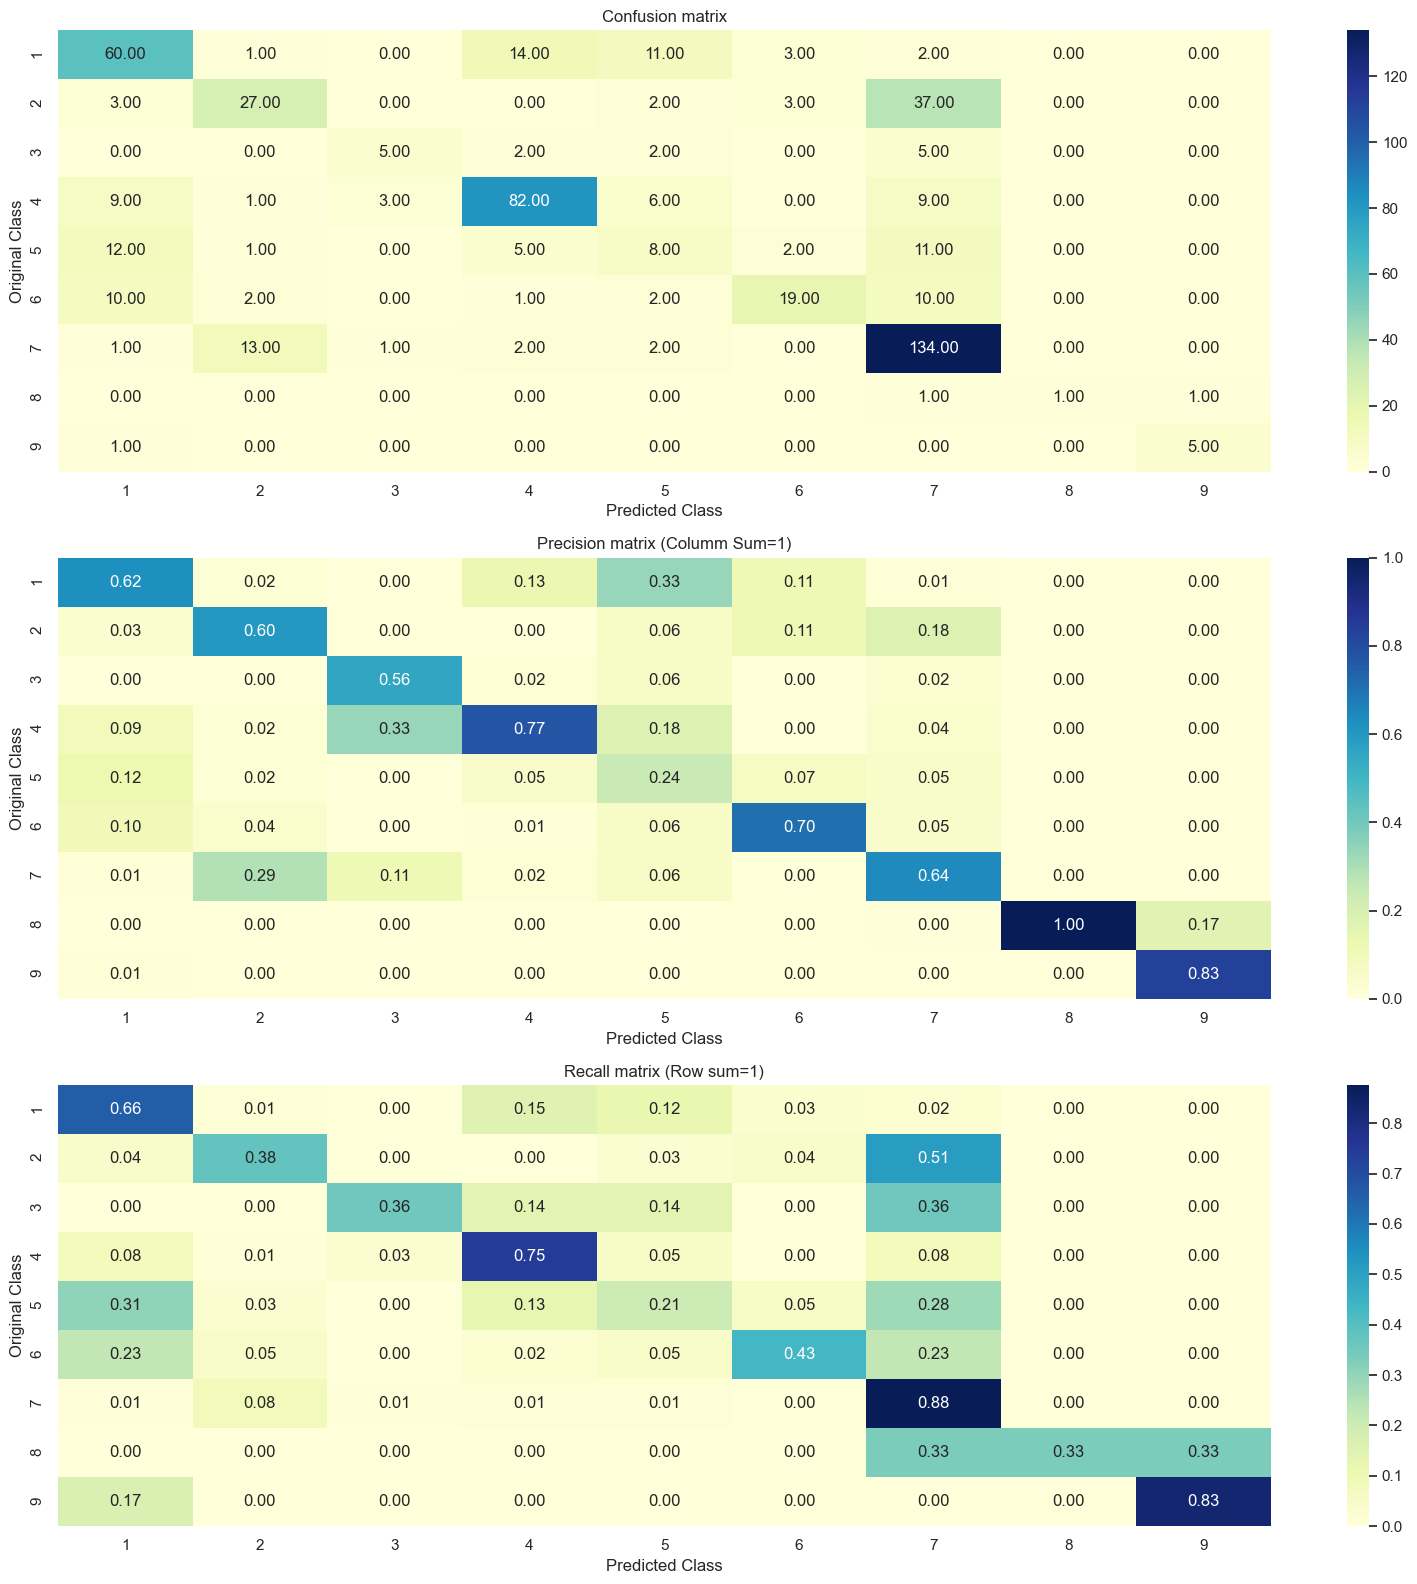

In [44]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### Feature Importance Correctly Classified point

In [45]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [46]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.8104 0.1318 0.0037 0.0126 0.0098 0.0058 0.0193 0.0046 0.002 ]]
Actual Class : 1
--------------------------------------------------
252 Text feature [aggregated] present in test data point [True]
292 Text feature [processing] present in test data point [True]
342 Text feature [expressing] present in test data point [True]
367 Text feature [archaebacterial] present in test data point [True]
400 Text feature [contest] present in test data point [True]
412 Text feature [premature] present in test data point [True]
Out of the top  500  features  6 are present in query point


#### Feature Importance  Incorrectly Classified point

In [47]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0168 0.1361 0.0015 0.0186 0.0058 0.0051 0.8105 0.0043 0.0013]]
Actual Class : 7
--------------------------------------------------
87 Text feature [constitutive] present in test data point [True]
119 Text feature [tx] present in test data point [True]
123 Text feature [thyroid] present in test data point [True]
133 Text feature [constitutively] present in test data point [True]
135 Text feature [3t3] present in test data point [True]
159 Text feature [expressing] present in test data point [True]
193 Text feature [ligand] present in test data point [True]
207 Text feature [function] present in test data point [True]
213 Text feature [egf] present in test data point [True]
221 Text feature [activator] present in test data point [True]
238 Text feature [activating] present in test data point [True]
272 Text feature [receptors] present in test data point [True]
276 Text feature [extracellular] present in test data point [True]
315 Tex

### Linear Support Vector Machines

#### Hyper paramter tuning

for C = 1e-05
Log Loss : 1.3253802575992406
for C = 0.0001
Log Loss : 1.2873766645967677
for C = 0.001
Log Loss : 1.1596908320059625
for C = 0.01
Log Loss : 1.1847648563983895
for C = 0.1
Log Loss : 1.3879701310719252
for C = 1
Log Loss : 1.6675922322714856
for C = 10
Log Loss : 1.6838340386799557
for C = 100
Log Loss : 1.6838340836749632


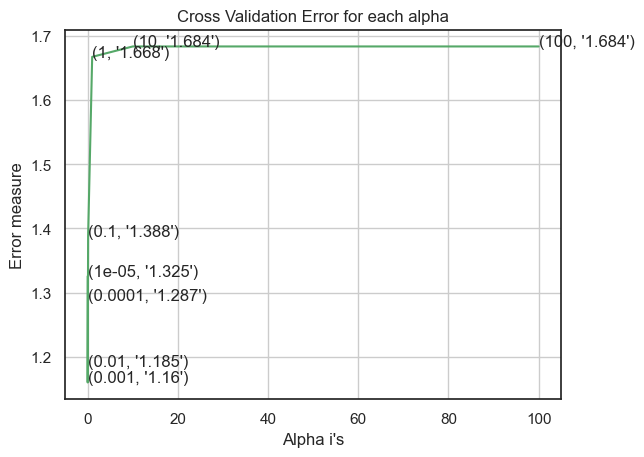

For values of best alpha =  0.001 The train log loss is: 0.5220013914091015
For values of best alpha =  0.001 The cross validation log loss is: 1.1596908320059625
For values of best alpha =  0.001 The test log loss is: 1.168790814376124


In [48]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Testing model with best hyper parameters

Log loss : 1.1596908320059625
Number of mis-classified points : 0.3684210526315789


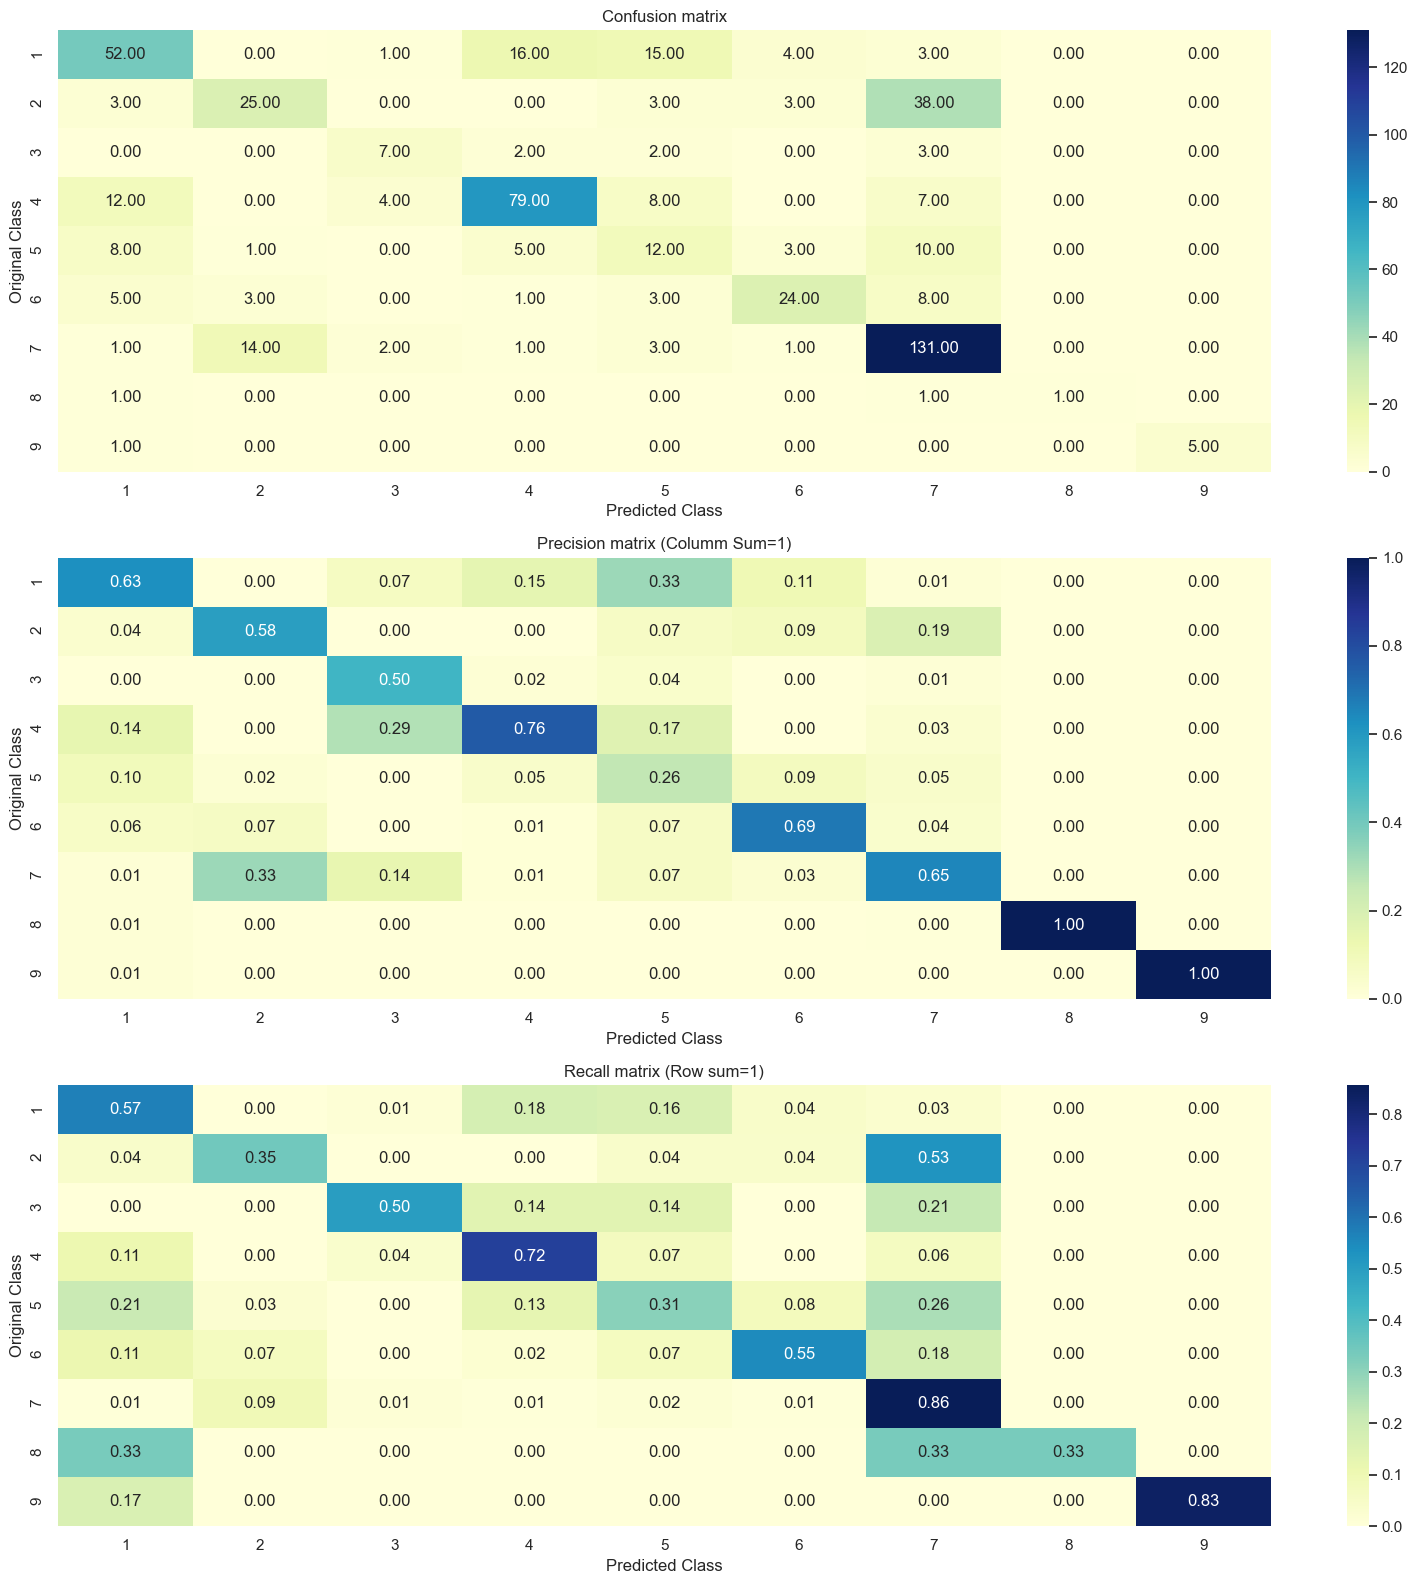

In [49]:
# clf = SVC(C=alpha[best_alpha],kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### Feature Importance Correctly classified point

In [50]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.7576 0.0853 0.009  0.0327 0.023  0.0188 0.0649 0.0035 0.0051]]
Actual Class : 1
--------------------------------------------------
414 Text feature [aggregated] present in test data point [True]
Out of the top  500  features  1 are present in query point


#### Feature Importance Incorrectly classified point

In [51]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.035  0.1263 0.0046 0.0505 0.0199 0.0145 0.7402 0.0037 0.0055]]
Actual Class : 7
--------------------------------------------------
Out of the top  500  features  0 are present in query point


### Random Forest Classifier

#### Hyper paramter tuning (With One hot Encoding)

In [52]:
train_x_onehotCoding = train_x_onehotCoding.toarray()
cv_x_onehotCoding = cv_x_onehotCoding.toarray()
test_x_onehotCoding = test_x_onehotCoding.toarray()

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2202756659342509
for n_estimators = 100 and max depth =  10
Log Loss : 1.159525801135362
for n_estimators = 200 and max depth =  5
Log Loss : 1.2190339692179335
for n_estimators = 200 and max depth =  10
Log Loss : 1.1575317490127754
for n_estimators = 500 and max depth =  5
Log Loss : 1.2133198177641868
for n_estimators = 500 and max depth =  10
Log Loss : 1.1525485271317322
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2117340996922596
for n_estimators = 1000 and max depth =  10
Log Loss : 1.151182438108908
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2098738302870609
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1505321184953212
For values of best estimator =  2000 The train log loss is: 0.6727539823286758
For values of best estimator =  2000 The cross validation log loss is: 1.1505321184953212
For values of best estimator =  2000 The test log loss is: 1.1632614990596637


#### Testing model with best hyper parameters (One Hot Encoding)

Log loss : 1.1505321184953212
Number of mis-classified points : 0.35150375939849626


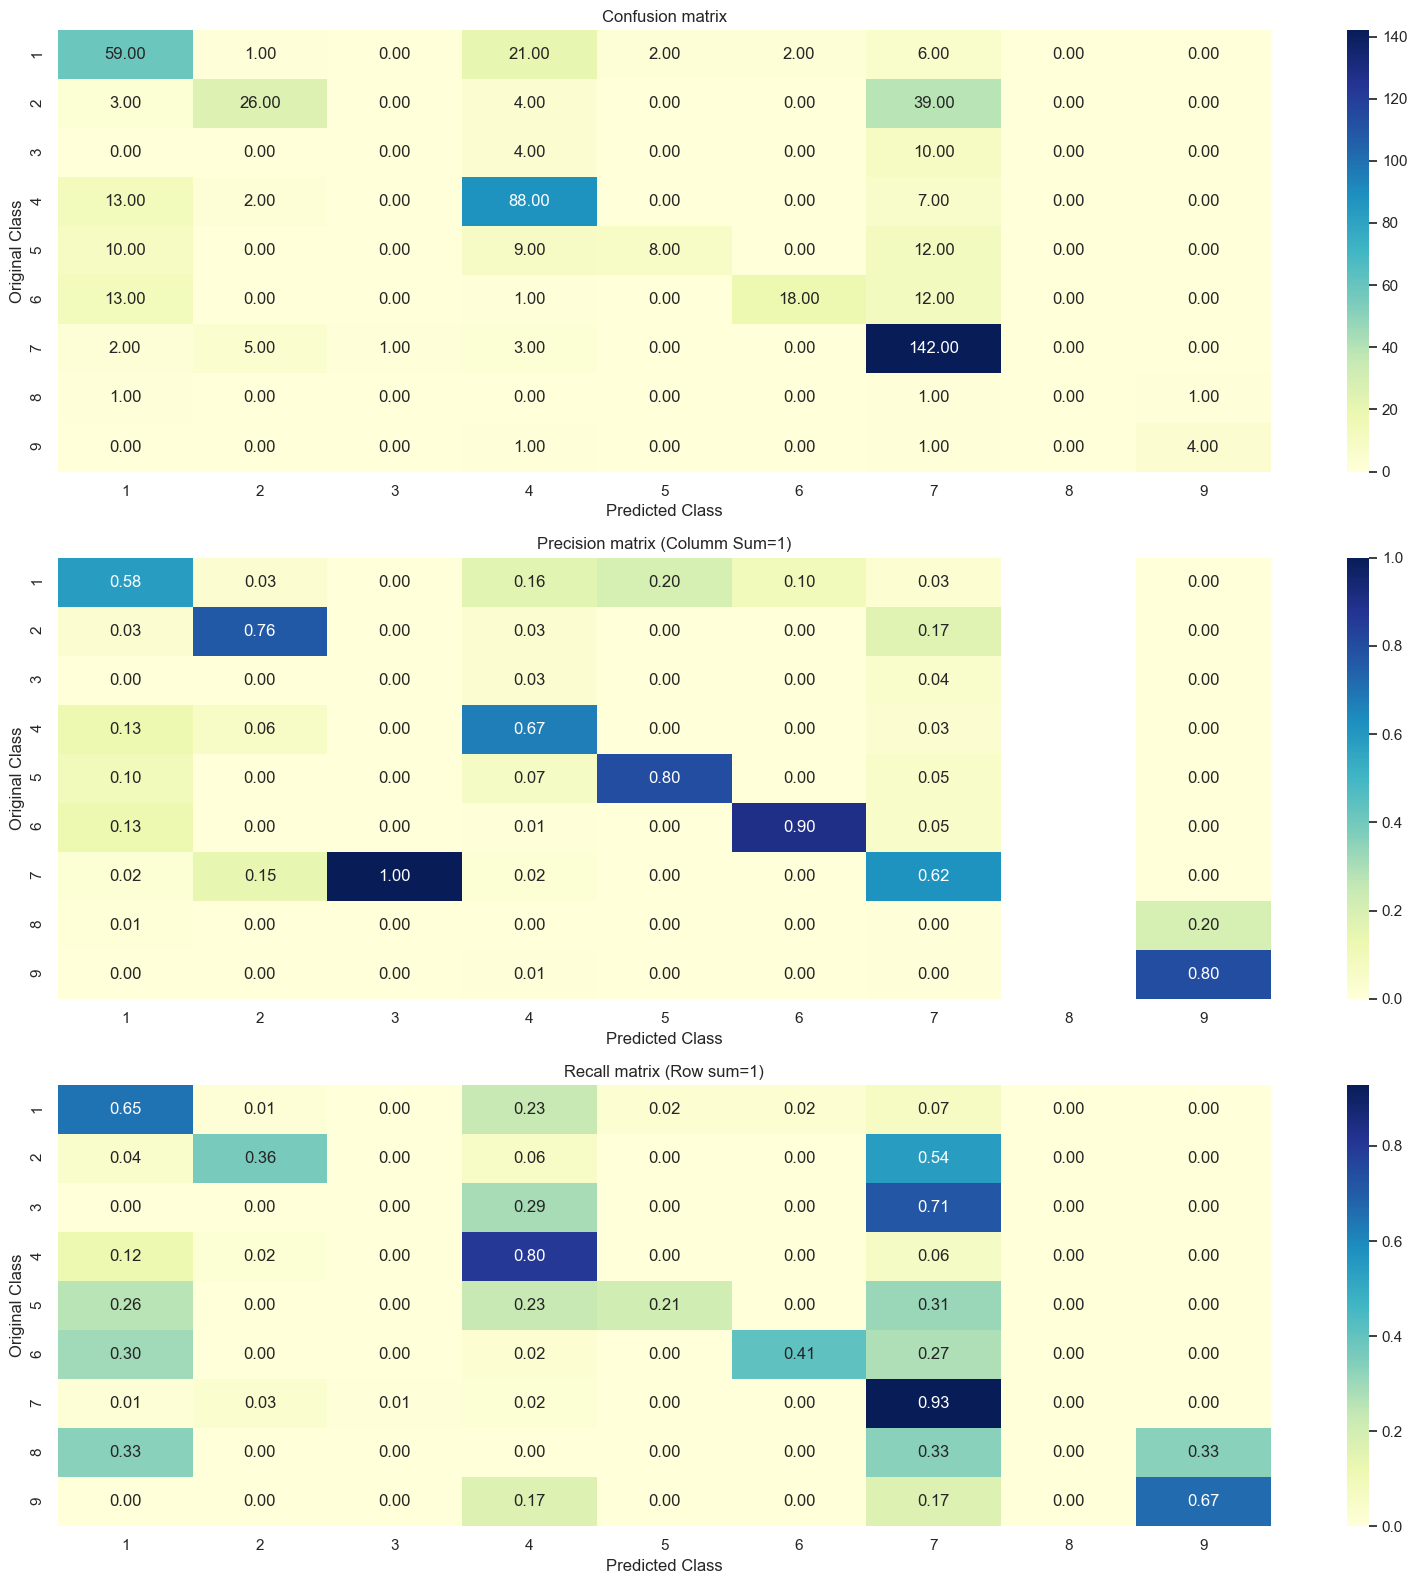

In [53]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### Feature Importance Correctly Classified point

In [54]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

#### Feature Importance Inorrectly Classified point

In [ ]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

#### Hyper paramter tuning (With Response Coding)

In [ ]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Testing model with best hyper parameters (Response Coding)

In [ ]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

#### Feature Importance Correctly Classified point

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

#### Feature Importance Incorrectly Classified point

In [ ]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

### Future Work
- Apply All the models with tf-idf features (Replace CountVectorizer with tfidfVectorizer and run the same cells)
- Instead of using all the words in the dataset, use only the top 1000 words based of tf-idf values</li>
- Apply Logistic regression with CountVectorizer Features, including both unigrams and bigrams</li>
- Try any of the feature engineering techniques discussed in the course to reduce the CV and test log-loss to a value less than 1.0